# Regress Wine Quality
## by Georgios Pligoropoulos

In [1]:
#%load_ext autoreload
%reload_ext autoreload
%autoreload 2

In [2]:
# -*- coding: UTF-8 -*-
from __future__ import division#, print_function # Imports from __future__ since we're running Python 2
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, log_loss
from scipy.stats import skew
from scipy.stats import boxcox
%matplotlib inline
from matplotlib import rcParams
from imblearn.over_sampling import SMOTE
rcParams['figure.figsize'] = (15, 7)

In [3]:
seed = 160184
random_state = np.random.RandomState(seed=seed)

## Setting up...

In [4]:
def loadDataset(data_path):
    return pd.read_csv(data_path, delimiter = ';', encoding='utf-8')

In [5]:
# Your code goes here
df = loadDataset('winequality-red.csv')
df.shape

(1599, 12)

In [6]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
print "number of instances:"
len(df)

number of instances:


1599

In [8]:
print "number of attributes:"
len(df.columns)

number of attributes:


12

In [9]:
df.sample(n=5, random_state=random_state)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1165,8.5,0.440,0.50,1.9,0.369,15.0,38.0,0.99634,3.01,1.10,9.4,5
526,7.3,0.365,0.49,2.5,0.088,39.0,106.0,0.99660,3.36,0.78,11.0,5
902,7.4,0.635,0.10,2.4,0.080,16.0,33.0,0.99736,3.58,0.69,10.8,7
1131,5.9,0.190,0.21,1.7,0.045,57.0,135.0,0.99341,3.32,0.44,9.5,5
784,7.1,0.590,0.01,2.5,0.077,20.0,85.0,0.99746,3.55,0.59,9.8,5


### Do we have any missing attributes?

In [10]:
np.sum(df.isnull())

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

In [11]:
assert np.sum(np.sum(df.isnull())) == 0, "if this fails your dataset has now missing attributes"

#### Note
It is good that we have zero missing attributes, so no downsampling or imputation is necessary

# Exploratory Data Analysis

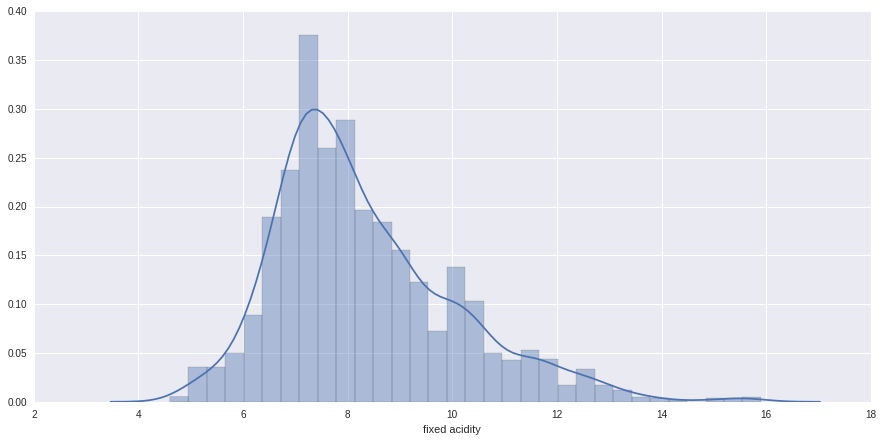

In [12]:
sns.distplot(df['fixed acidity'])
plt.show()

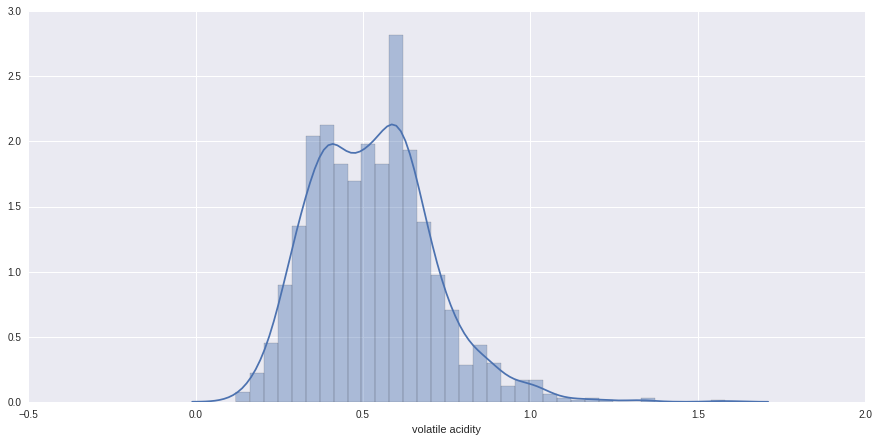

In [13]:
sns.distplot(df['volatile acidity'])
plt.show()

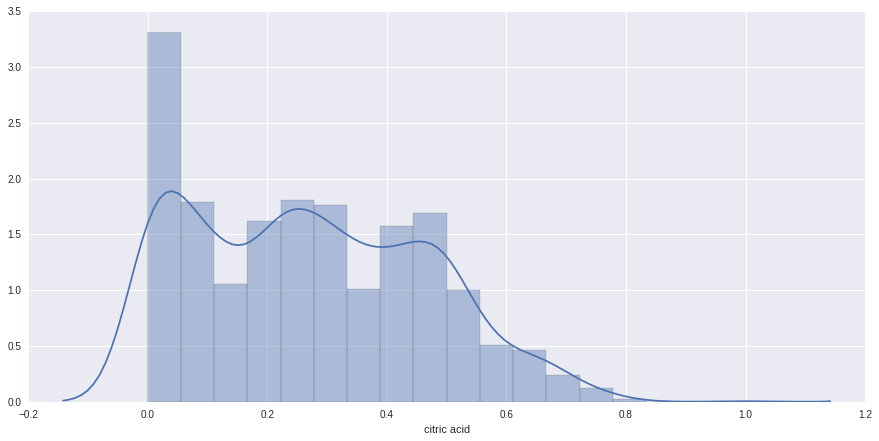

In [14]:
sns.distplot(df['citric acid'])
plt.show()

In [15]:
np.sum(df['citric acid'] == 0)

132

So we observe that citric acid sometimes is completely zero. TODO: should we preprocess it?

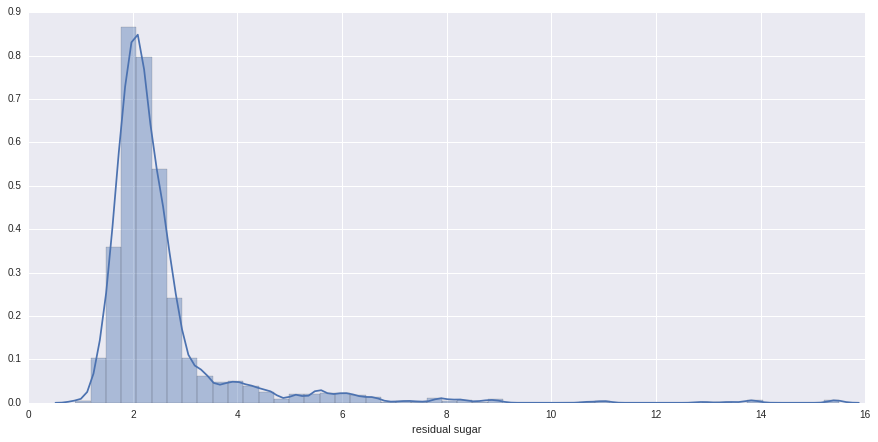

In [16]:
sns.distplot(df['residual sugar'])
plt.show()

In [17]:
skew(df['residual sugar'])

4.536394788805638

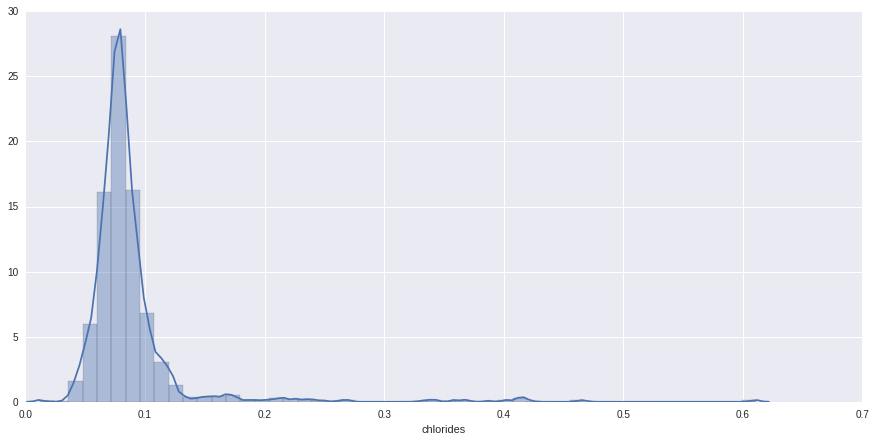

In [18]:
sns.distplot(df['chlorides'])
plt.show()

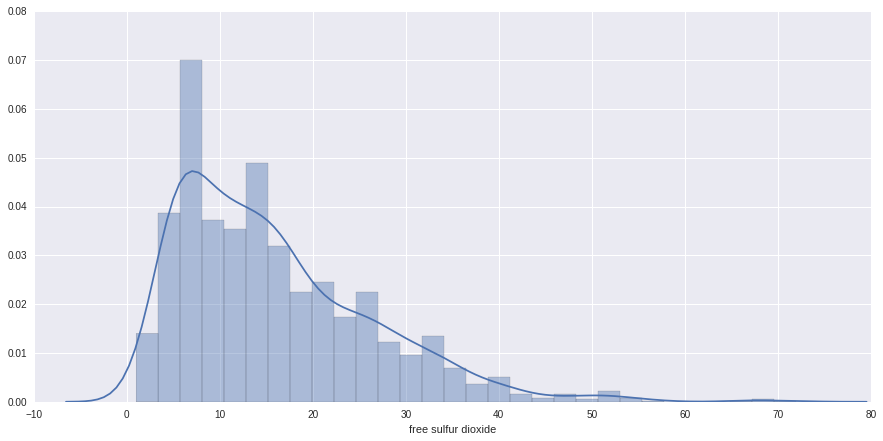

In [19]:
sns.distplot(df['free sulfur dioxide'])
plt.show()

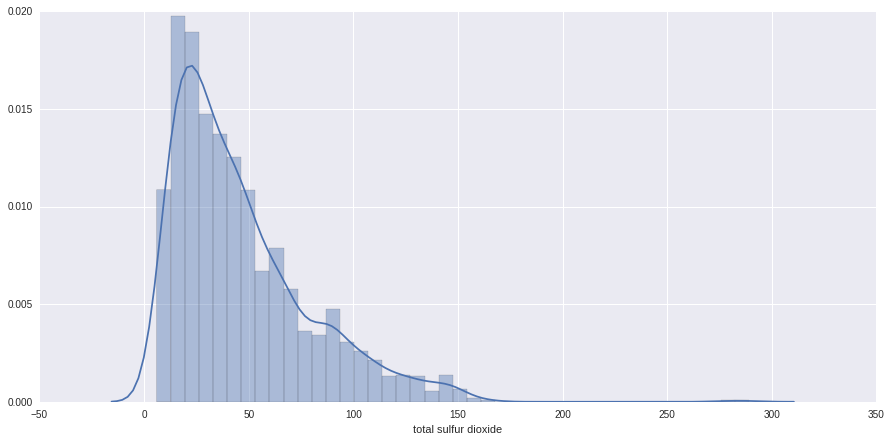

In [20]:
sns.distplot(df['total sulfur dioxide'])
plt.show()

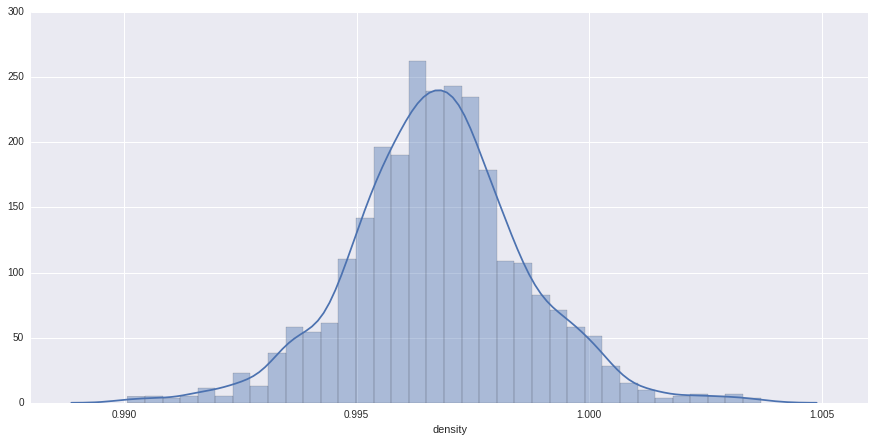

In [21]:
sns.distplot(df['density'])
plt.show()

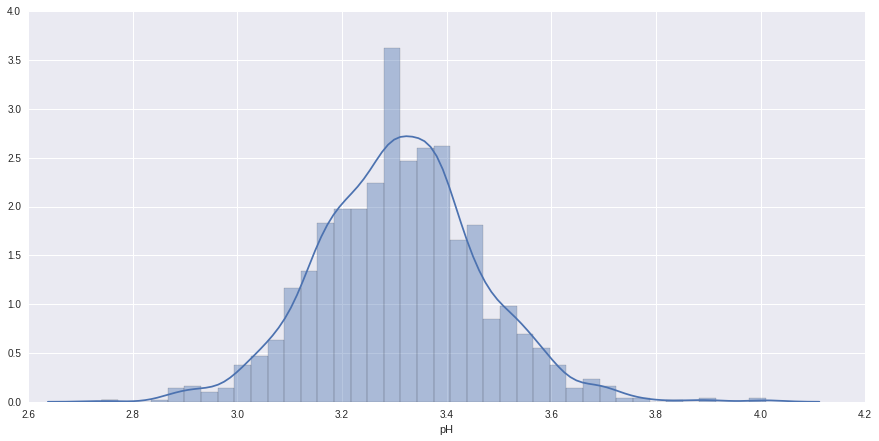

In [22]:
sns.distplot(df['pH'])
plt.show()

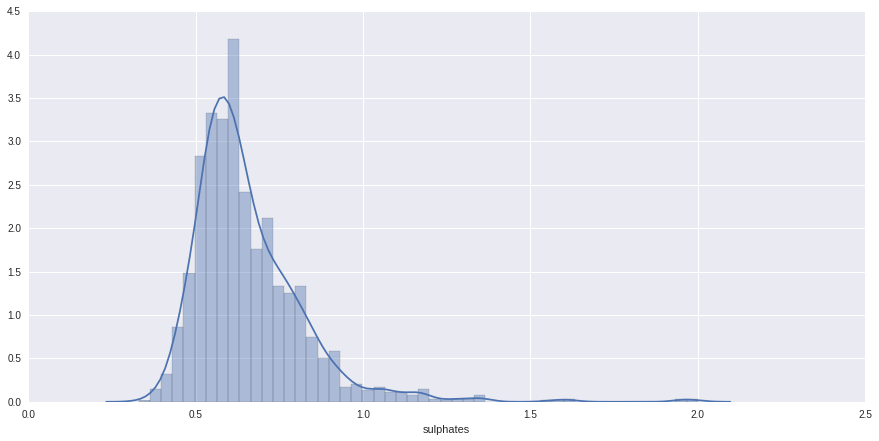

In [23]:
sns.distplot(df['sulphates'])
plt.show()

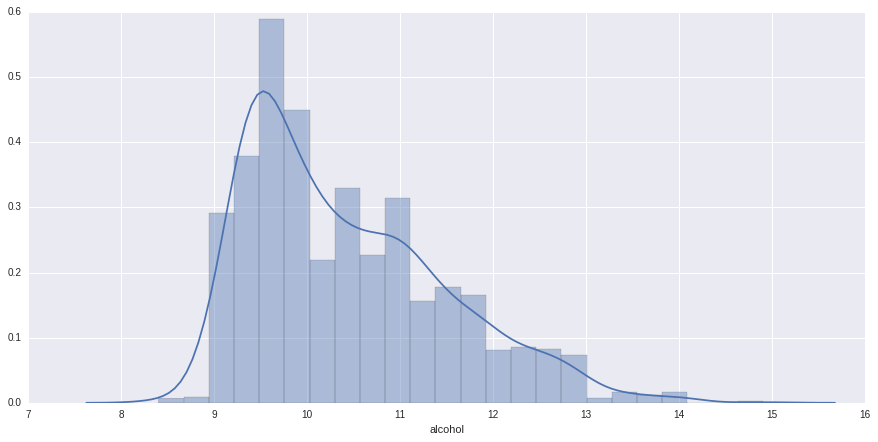

In [24]:
sns.distplot(df['alcohol'])
plt.show()

#### Notes
The conclusions from the above distribution plots is that most of the measurements have only positive values, we observe extreme values on the positive side in many cases and lots of distributions are quite skewed. A log transformation is expected to help most of these cases, except the Citric Acid where we have zero values.  
For Citric Acid we are going to use the transformation log(x + 1) which has the nice property that zero still maps to zero: https://stats.stackexchange.com/questions/1444/how-should-i-transform-non-negative-data-including-zeros

### Apply log transformations for skewed distributions

In [25]:
target_name = 'quality'

In [26]:
XX = df.drop(labels=[target_name], axis=1)
XX.shape

(1599, 11)

In [27]:
from collections import OrderedDict

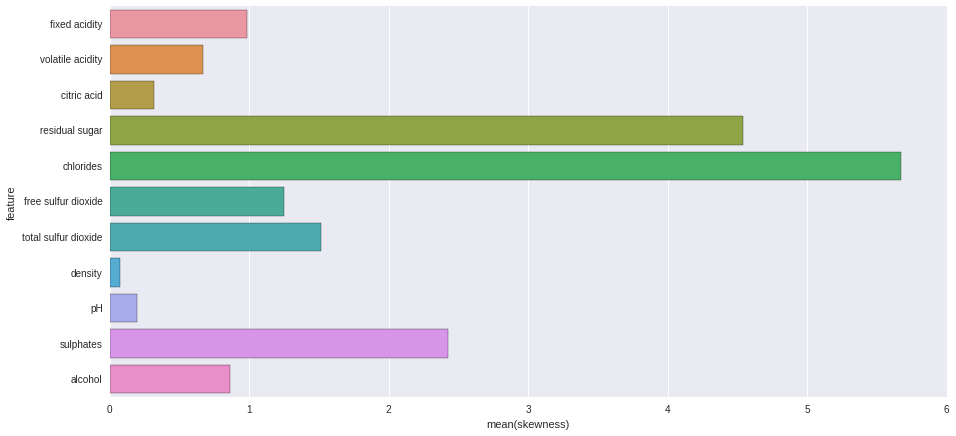

In [28]:
skews = OrderedDict(zip(XX.columns, skew(XX)))
skews = pd.DataFrame({
        'feature': skews.keys(),
        'skewness': skews.values(),
    })
sns.barplot(y='feature', x='skewness', data=skews)
plt.show()

It is obvious that apart density and pH all the rest of the attributes should be tranformed. By default this helps learning in most machine learning models

In [29]:
#MyOutliers.getBoundaries(skews['skewness'])

In [30]:
bounds = np.percentile(skews['skewness'], [10, 90])
bounds

array([ 0.19350176,  4.53639479])

In [31]:
features_to_transform = skews[skews['skewness'] > bounds[0]]['feature']#.values
features_to_transform

0            fixed acidity
1         volatile acidity
2              citric acid
3           residual sugar
4                chlorides
5      free sulfur dioxide
6     total sulfur dioxide
9                sulphates
10                 alcohol
Name: feature, dtype: object

In [32]:
for cur_feat in features_to_transform:
    if cur_feat == 'citric acid':
        XX[cur_feat] += 1
    XX[cur_feat] = np.log(XX[cur_feat])

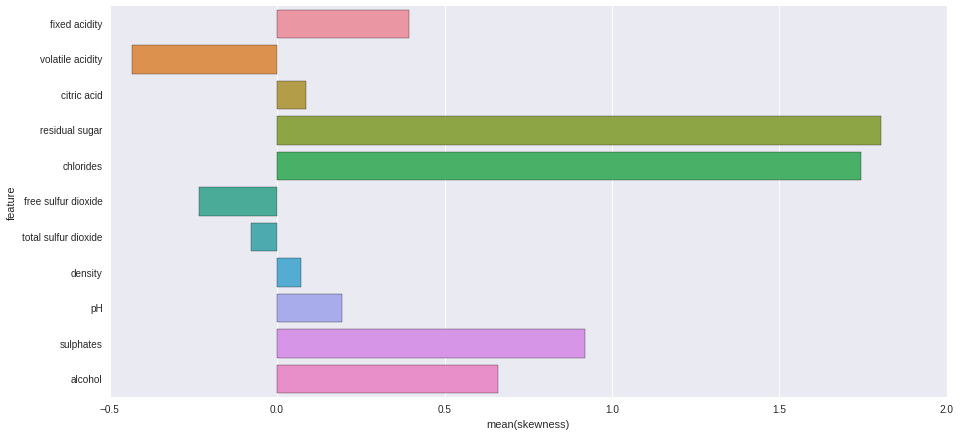

In [33]:
skews = OrderedDict(zip(XX.columns, skew(XX)))
skews = pd.DataFrame({
        'feature': skews.keys(),
        'skewness': skews.values(),
    })
sns.barplot(y='feature', x='skewness', data=skews)
plt.show()

## Outlier detection

In [34]:
from tukey_outliers_helper import TukeyOutliersHelper

In [35]:
bounds = TukeyOutliersHelper().getBoundsFromDataFrame(XX, kk=3.0, outlier_columns=XX.columns)
bounds

fixed acidity             (1.18276868402, 2.99652958408)
volatile acidity         (-2.42757285155, 1.03967720906)
citric acid             (-0.707259829875, 1.14409439773)
residual sugar          (-0.299118790393, 1.89648412159)
chlorides               (-3.41320332178, -1.65400232381)
free sulfur dioxide      (-1.34992671695, 6.34035930373)
total sulfur dioxide    (-0.017233341702, 7.23541018011)
density                              (0.988895, 1.00454)
pH                                          (2.64, 3.97)
sulphates                (-1.4472157685, 0.534668022908)
alcohol                   (1.78433186947, 2.87390503745)
dtype: object

In [36]:
counts = TukeyOutliersHelper.countOutliersDataPoints(XX, bounds)
counts

fixed acidity            0
volatile acidity         0
citric acid              0
residual sugar          32
chlorides               45
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       2
sulphates                4
alcohol                  0
dtype: object

In [37]:
fatal_inds_set = TukeyOutliersHelper.getOutlierDataPoints(XX, bounds)

In [38]:
print "we will be losing {} fraction of the total instances".format(len(fatal_inds_set) / len(XX))

we will be losing 0.0481550969356 fraction of the total instances


In [39]:
keep_inds = list(set(range(len(XX))).difference(fatal_inds_set))
assert len(keep_inds) + len(fatal_inds_set) == len(XX)

In [40]:
XX_no_outliers = XX.iloc[keep_inds]
XX_no_outliers.shape

(1522, 11)

In [41]:
yy = df[target_name]
yy.shape

(1599,)

In [42]:
yy_no_outliers = yy.iloc[keep_inds]
yy_no_outliers.shape

(1522,)

### Side-note
We could also explore Isolation Forest and other similar techniques but it is not of high priority for a first version of our model

# Exploring the target
Do we have a balanced/imbalanced dataset? etc.

In [43]:
np.unique(yy_no_outliers)

array([3, 4, 5, 6, 7, 8])

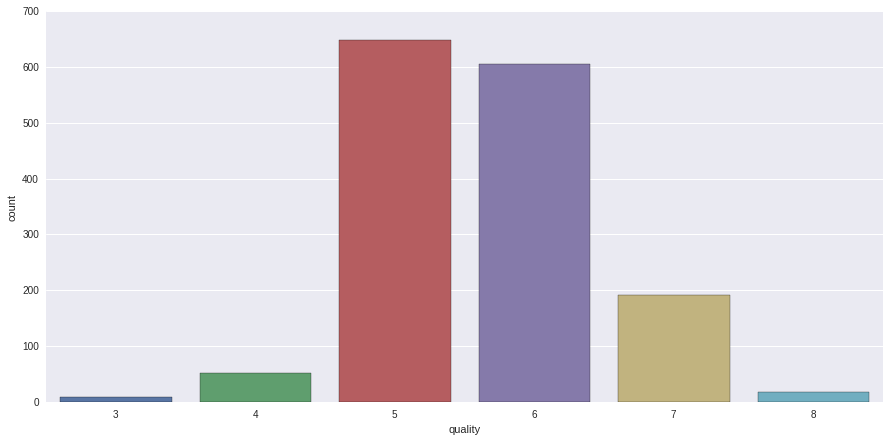

In [44]:
sns.countplot(yy_no_outliers)
plt.show()

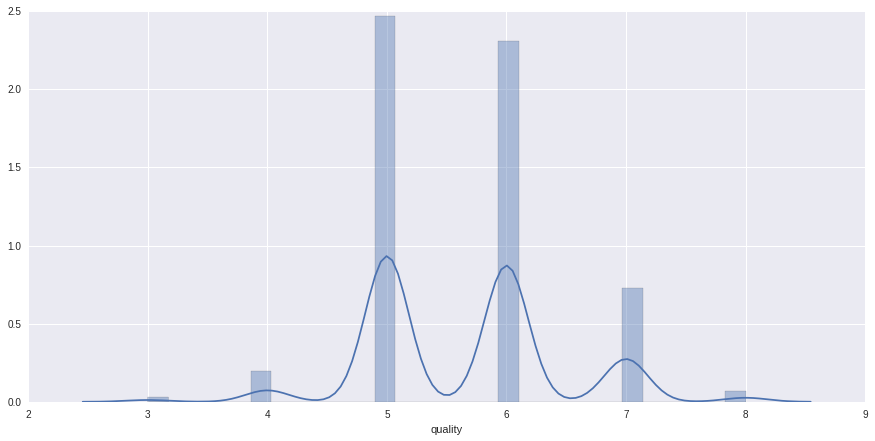

In [45]:
sns.distplot(yy_no_outliers)
plt.show()

## Exploring Quality vs Attributes

In [46]:
df_clean = pd.concat((XX_no_outliers, yy_no_outliers.to_frame()), axis=1)
df_clean.shape

(1522, 12)

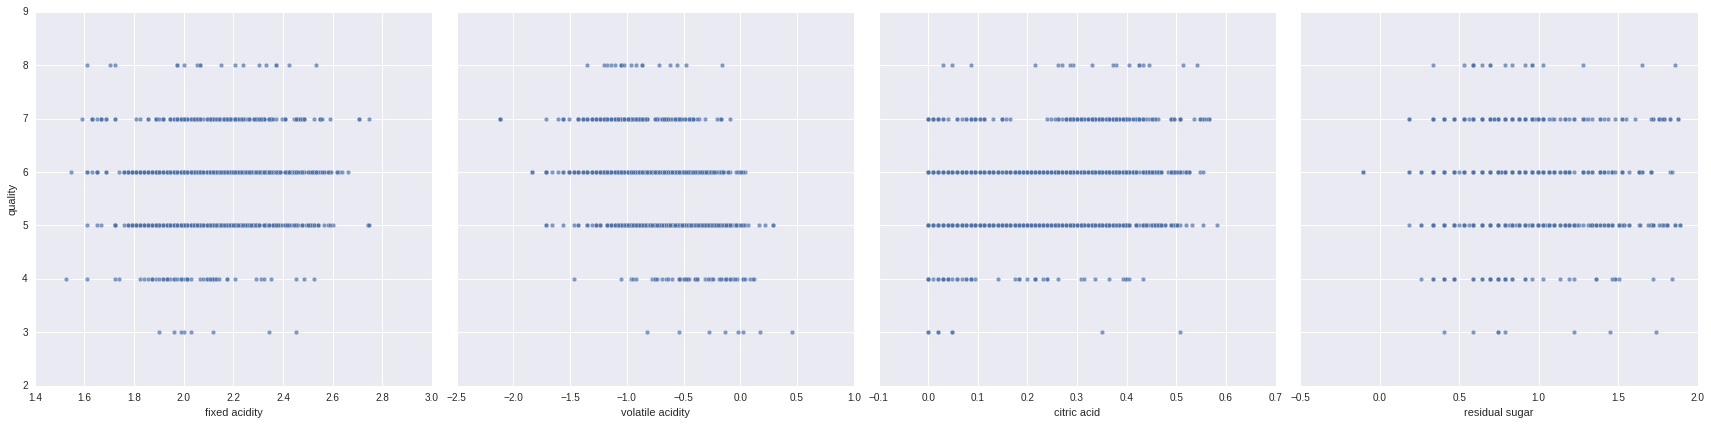

In [47]:
sns.pairplot(df_clean, x_vars = df_clean.columns[:4], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

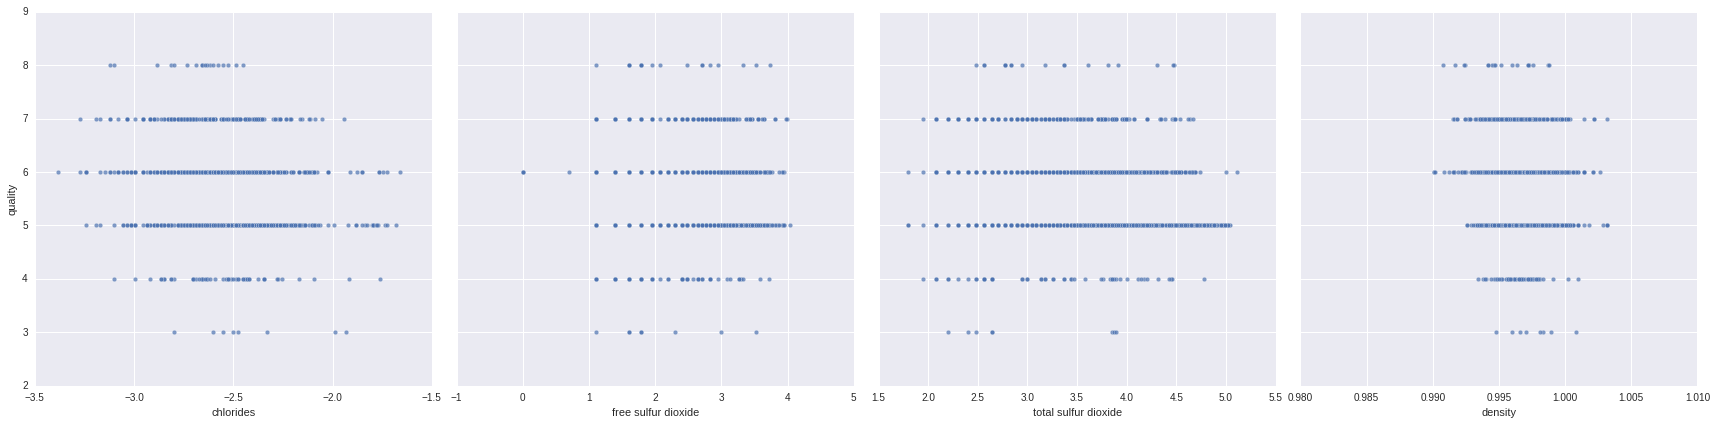

In [48]:
sns.pairplot(df_clean, x_vars = df_clean.columns[4:8], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

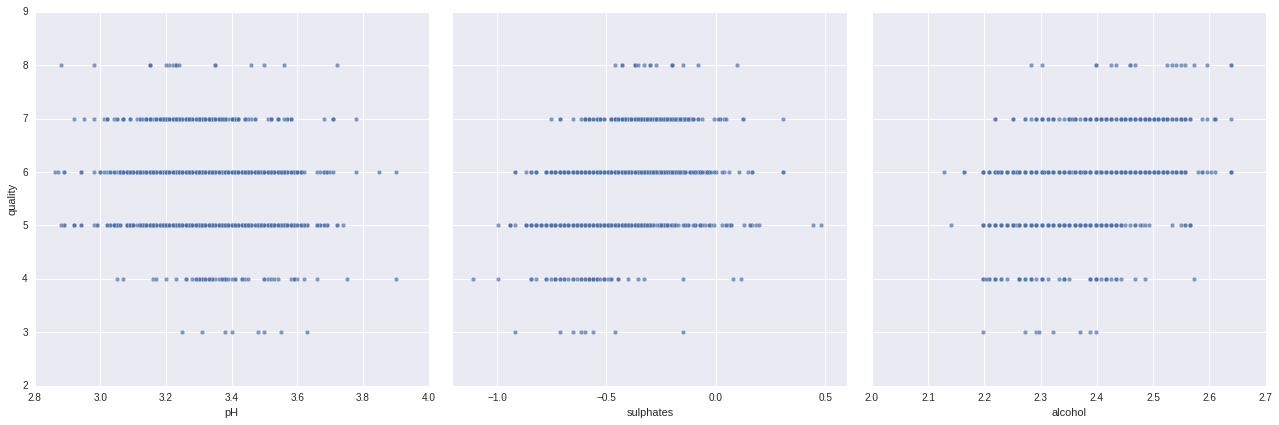

In [49]:
sns.pairplot(df_clean, x_vars = df_clean.columns[8:11], y_vars=[target_name], diag_kind='kde',
            plot_kws={'hold' : True, 'marker': 'o', 'alpha': 0.7},size=6)
plt.show()

In [50]:
from scipy.stats import pearsonr

In [51]:
corrs = OrderedDict([(col, pearsonr(XX_no_outliers[col], yy_no_outliers)) for col in XX_no_outliers.columns])
corrs = pd.DataFrame(index = corrs.keys(), data={
        'corr_coef': [corr[0] for corr in corrs.values()],
        'p_value': [corr[1] for corr in corrs.values()],
    })

In [52]:
corrs.applymap(lambda xx : abs(xx)).sort_values(by='corr_coef', ascending=False).rename(columns={
        'corr_coef': 'absolute correlation coefficient'
    })

,absolute correlation coefficient,p_value
alcohol,0.480277,1.191126e-88
volatile acidity,0.389662,2.307606e-56
sulphates,0.374089,9.485586e-52
citric acid,0.238494,3.980587e-21
chlorides,0.180448,1.318875e-12
total sulfur dioxide,0.173938,8.350876e-12
density,0.168068,4.156036e-11
fixed acidity,0.123273,1.409315e-06
pH,0.076604,2.785561e-03
free sulfur dioxide,0.049259,5.469211e-02


We are happy to express that pearson correlation agrees with our bare-eye observations that the strongest correlation between our features and the target value of quality are given indeed by the top four: sulphates, alcohol, citric acid and volatile acidity

Pearson correlation agrees with us that the residual sugar has almost no correlation with the quality of the red wine.
However Pearson correlation expresses that chlorides have a small correlation with the quality of the red wine, still quite small so our observation was not that bad.

Note that pearson correlation is a first indication of whether a factor that plays a weaker or stronger role to predicting the quality of the wine. We should build our classifier to quantify it better 

# Scaling

By having all of our distributions having a bell-shaped curve we can make an assumption of gaussian distribution and normalize accordingly by subtracting the mean, to remove bias, and dividing with the standard deviation to remove scale

In [53]:
from sklearn.preprocessing import StandardScaler

In [54]:
XX_sc = StandardScaler().fit_transform(XX_no_outliers)
XX_sc.shape

(1522, 11)

# Polynomial non-linear features

In [55]:
from sklearn.preprocessing import PolynomialFeatures

In [56]:
pf = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)

In [57]:
XX_poly = pf.fit_transform(XX_sc)
XX_poly.shape

(1522, 363)

# Dimensionality reduction
Above we are observing that the bare pairplots between two attributes do not seem to provide a strong separate of the classes.  
Our alternative is going to be to use multiple techniques of bring down the dimensionality from 11 dimension to only 2 and then plot

In [58]:
from scatter_2d_label import scatter_2d_label

### PCA

In [59]:
from sklearn.decomposition import PCA # Import the PCA module

In [60]:
XX_pca = PCA(n_components=2, random_state=random_state).fit_transform(XX_sc)
XX_pca.shape

(1522, 2)

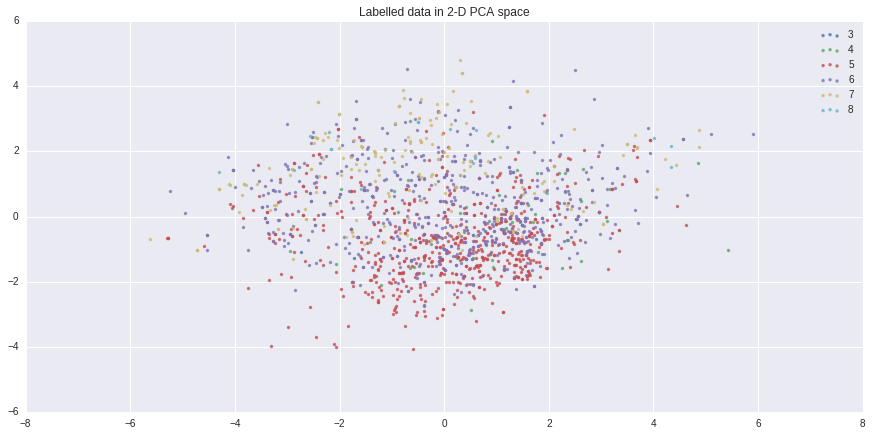

In [61]:
plt.figure(figsize=(15,7))
scatter_2d_label(XX_pca, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2-D PCA space')
plt.legend(loc='best', scatterpoints=3) # Ask matplotlib to place the legend where it thinks best
plt.show()

Treating this as a classification task will be difficult because even after PCA we see that the classes are quite mixed and they do not form any apparent classes. We are going to continue building our classifier, however we might consider later to treat this like a regression task where intermediate values are allowed as well

### Isomap

In [62]:
from sklearn.manifold import Isomap

In [63]:
isomap = Isomap(n_components=2, n_neighbors=5)
XX_isomap = isomap.fit_transform(XX_sc)
XX_isomap.shape

(1522, 2)

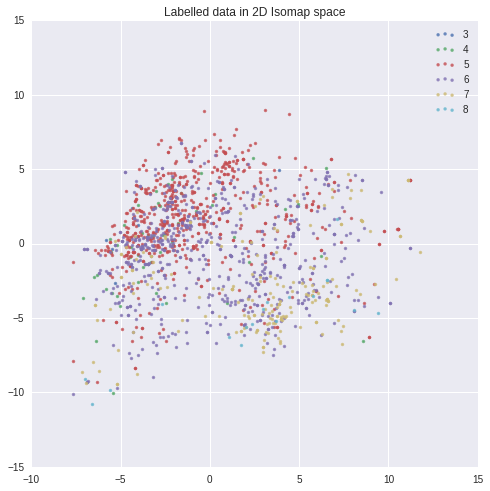

In [64]:
plt.figure(figsize=(8,8))
scatter_2d_label(XX_isomap, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D Isomap space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

We see a good seperation between quality-5 and quality-7 but the rest of the classes are mixed

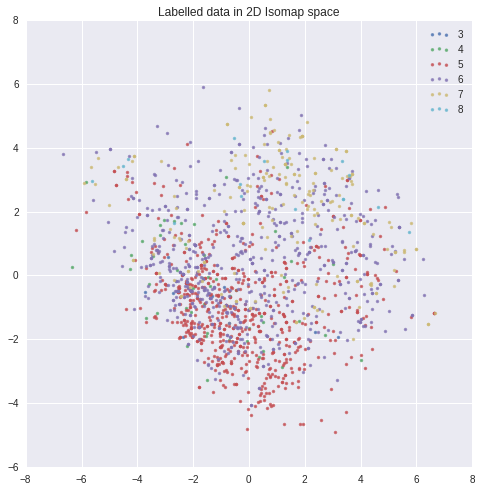

In [65]:
isomap = Isomap(n_components=2, n_neighbors=50)
XX_isomap = isomap.fit_transform(XX_sc)
plt.figure(figsize=(8,8))
scatter_2d_label(XX_isomap, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D Isomap space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

### TSNE

In [66]:
from sklearn.manifold import TSNE

In [67]:
%%time
tSne = TSNE(n_components=2, perplexity=5, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)

CPU times: user 10.3 s, sys: 1.26 s, total: 11.5 s
Wall time: 11.5 s


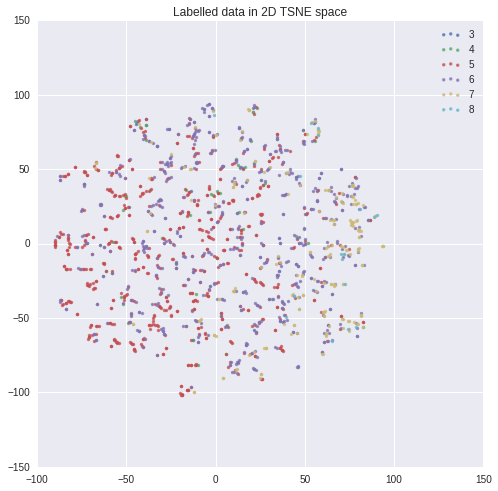

In [68]:
plt.figure(figsize=(8,8))
scatter_2d_label(XX_tsne, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D TSNE space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

In [69]:
%%time
tSne = TSNE(n_components=2, perplexity=30, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)

CPU times: user 21.9 s, sys: 1.02 s, total: 22.9 s
Wall time: 22.9 s


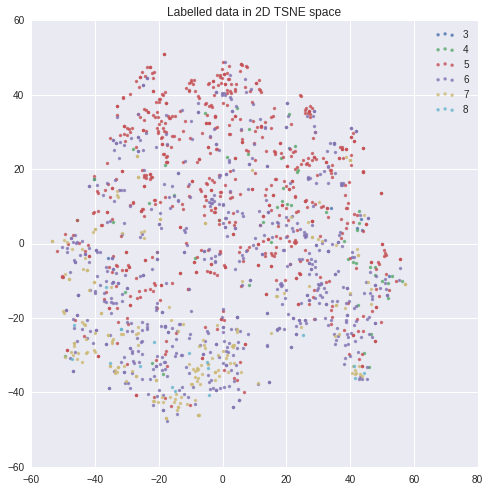

In [70]:
plt.figure(figsize=(8,8))
scatter_2d_label(XX_tsne, yy_no_outliers.values, alpha=0.75)
plt.title('Labelled data in 2D TSNE space')
plt.legend(loc='best', scatterpoints=3)
plt.show()

We see that TSNE with perplexity 30 has not been able to separate the classes but has been able to construct small neighbors where points of the same class are concentrated.

This is beneficial for algorithms such as K-neighbors classifiers that suffer from the curse of dimensionality but are able to produce complex decision boundaries

In [71]:
%%time
tSne = TSNE(n_components=3, perplexity=100, random_state=random_state)
XX_tsne = tSne.fit_transform(XX_sc)
XX_tsne.shape

CPU times: user 1min 57s, sys: 1.1 s, total: 1min 58s
Wall time: 1min 58s


# Train test split
We need for all the possible inputs and the targets that we are going to use to separate the ones for testing

In [72]:
#having a relatively small dataset we are going to use 90% of the inputs for training and only 10% for testing
train_fraction = 0.80
test_fraction = 1.0 - train_fraction
test_fraction

0.19999999999999996

In [73]:
no_outliers_len = len(XX_poly)
no_outliers_len

1522

In [74]:
train_len = int(no_outliers_len * train_fraction)
test_len = no_outliers_len - train_len
train_len, test_len

(1217, 305)

In [75]:
#assumed uniform distribution per instance
# train_indices = random_state.choice(range(train_len), size=train_len, replace=False)
# assert len(np.unique(train_indices)) == train_len
# test_indices = list(set(range(no_outliers_len)).difference(train_indices))
# assert len(test_indices) == no_outliers_len - train_len

In [76]:
from sklearn.model_selection import StratifiedShuffleSplit

In [77]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=test_fraction)
sss

StratifiedShuffleSplit(n_splits=1,
            random_state=<mtrand.RandomState object at 0x7f9a17932820>,
            test_size=0.2, train_size=None)

In [78]:
for train_inds, test_inds in sss.split(XX_poly, yy_no_outliers):
    train_indices = train_inds
    test_indices = test_inds
    
train_indices.shape, test_indices.shape

((1217,), (305,))

In [79]:
XX_train = XX_poly[train_indices]
XX_test = XX_poly[test_indices]
XX_train.shape, XX_test.shape

((1217, 363), (305, 363))

In [80]:
XX_lowdim_train = XX_tsne[train_indices]
XX_lowdim_test = XX_tsne[test_indices]
XX_lowdim_train.shape, XX_lowdim_test.shape

((1217, 3), (305, 3))

In [81]:
yy_train = yy_no_outliers.iloc[train_indices].values.astype(np.int)
yy_test = yy_no_outliers.iloc[test_indices].values.astype(np.int)
yy_train.shape, yy_test.shape

((1217,), (305,))

In [82]:
yy_train_percents = np.array([list(yy_train).count(cur_class) / len(yy_train) for cur_class in np.unique(yy_train)])
yy_train_percents

array([ 0.00493016,  0.0336894 ,  0.42563681,  0.39852095,  0.12571898,
        0.0115037 ])

In [83]:
yy_test_percents = np.array([list(yy_test).count(cur_class) / len(yy_test) for cur_class in np.unique(yy_test)])
yy_test_percents

array([ 0.00655738,  0.03278689,  0.42622951,  0.39672131,  0.12459016,
        0.01311475])

In [84]:
assert np.allclose(yy_train_percents, yy_test_percents, rtol=1e-2, atol=1e-2), "make sure they are almost the same"

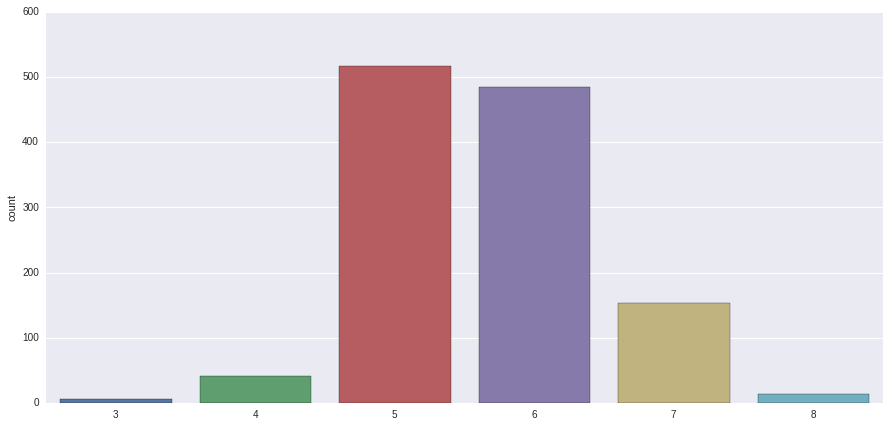

In [85]:
sns.countplot(yy_train)

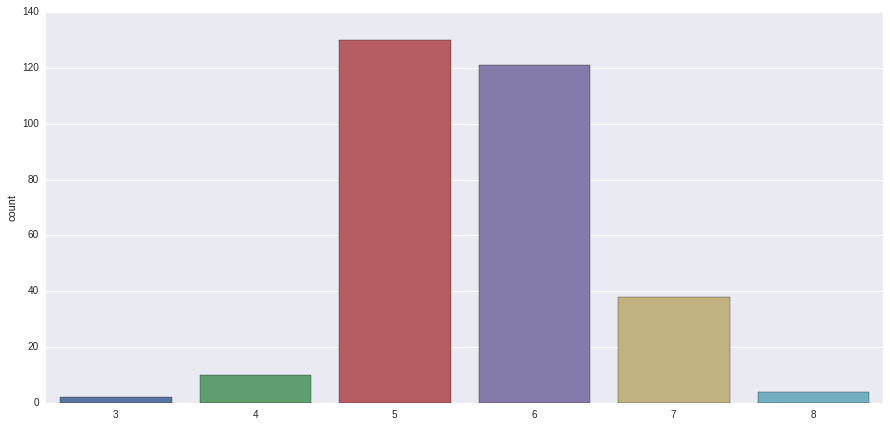

In [86]:
sns.countplot(yy_test)

# Baseline
Use the dummy regressor to set the baseline, any of our more advanced classifiers should perform better than the baseline

In [87]:
def purify_quality(qq):
    return np.clip(np.round(qq), 3, 8).astype(np.int)

In [88]:
from sklearn.dummy import DummyRegressor

In [89]:
from ecdf import ecdf
from bootstrap_replicates import draw_bootstrap_replicates

In [90]:
from sklearn.metrics import f1_score

### IMPORTANT NOTE:
Using the F1 score means that we want a classifier that takes into account all wine bottles the same.

While in a **business** case we would want to calculate precision for some bottles  
We would shift the probability threshold of classifying each class according to how much precision we would need for a particular class

In [91]:
#np.random.RandomState(seed=seed)
def dummy_regress(with_median):
    def _dummy_regress(inputs=XX_train, targets=yy_train):
        model = DummyRegressor(strategy='median' if with_median else 'mean')
        model.fit(inputs, targets)
        score = model.score(XX_test, yy_test)
        return score
        #preds = purify_quality(dc.predict(XX_test))
    #     return f1_score(yy_test, preds, 
    #                     average='weighted', #for imbalanced classes as in our case
    #                    )
    return _dummy_regress

In [92]:
dummy_regress(with_median=True)()

-0.19607843137254899

In [93]:
%%time
dummy_scores = draw_bootstrap_replicates(dummy_regress(with_median=True), 10000,
                                         random_state, XX_train, yy_train)

CPU times: user 15.7 s, sys: 0 ns, total: 15.7 s
Wall time: 15.7 s


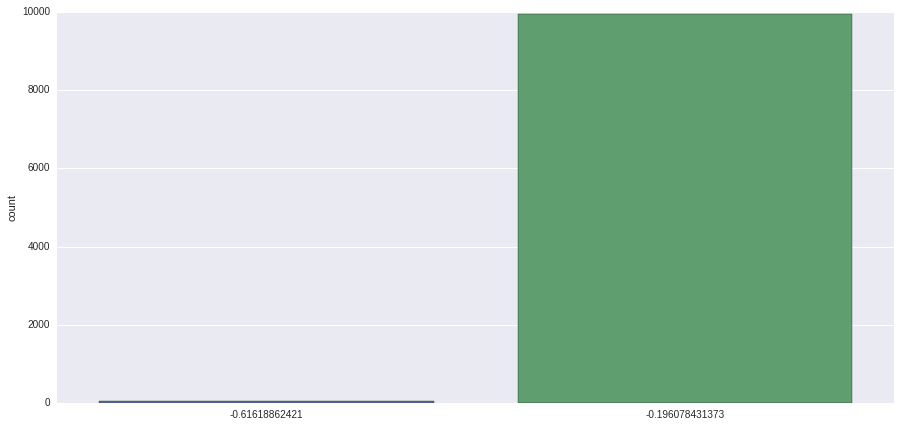

In [94]:
sns.countplot(dummy_scores)
plt.show()

In [95]:
print "95% confidence interval for the scores of the dummy classifier"
np.percentile(dummy_scores, [2.5, 97.5])

95% confidence interval for the scores of the dummy classifier


array([-0.19607843, -0.19607843])

#### repeating with mean (instead of median)

In [96]:
%%time
dummy_scores = draw_bootstrap_replicates(dummy_regress(with_median=False), 10000,
                                         random_state, XX_train, yy_train)

CPU times: user 14.6 s, sys: 4 ms, total: 14.6 s
Wall time: 14.6 s


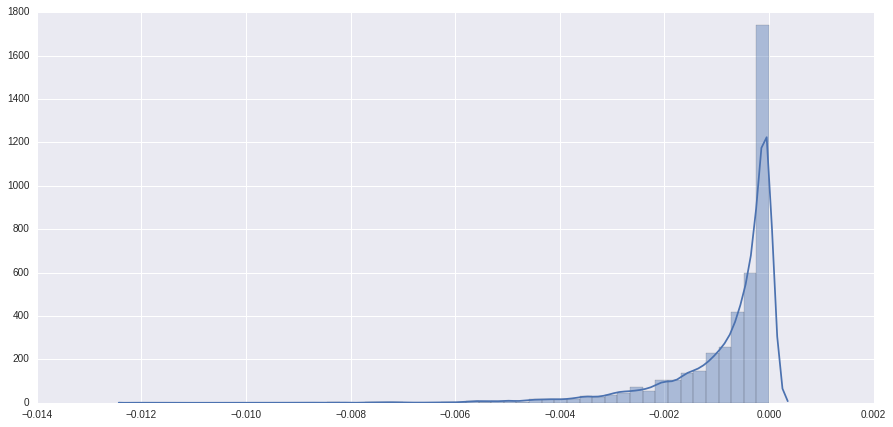

In [97]:
sns.distplot(dummy_scores)
plt.show()

In [98]:
print "95% confidence interval for the f1 scores of the dummy classifier"
np.percentile(dummy_scores, [2.5, 97.5])

95% confidence interval for the f1 scores of the dummy classifier


array([ -3.92277967e-03,  -8.57786802e-07])

The coefficient of determination with mean is very small while the coefficient of determination with median gave us at best -0.19 correlation coefficient strength

In [99]:
def fit_scatter(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    fig, ax = plt.subplots()
    ax.scatter(y_true, y_pred)
    ax.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=4)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')

In [100]:
preds = DummyRegressor(strategy='mean').fit(XX_train, yy_train).predict(XX_test)

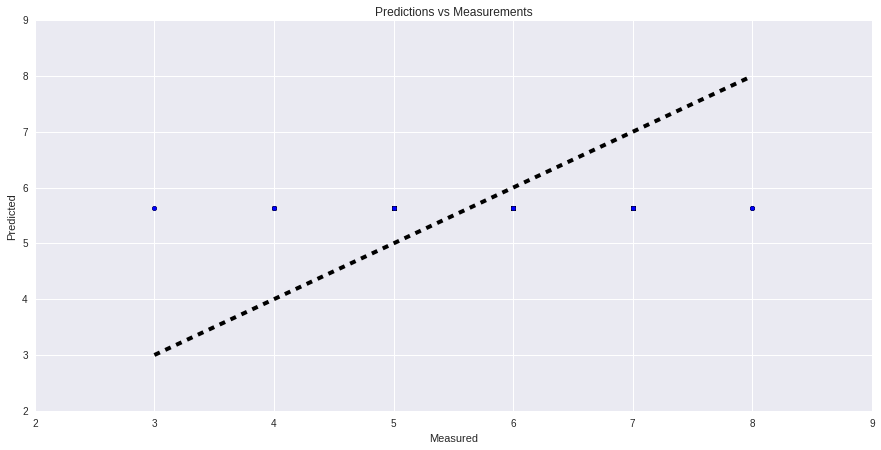

In [101]:
fit_scatter(y_true=yy_test, y_pred=preds)
plt.title('Predictions vs Measurements')
plt.show()

In [102]:
dummy_coefficient_of_determination = dummy_regress(with_median=False)(XX_train, yy_train)
dummy_coefficient_of_determination

-3.744337860878133e-06

If we do a better coefficient of determination than our baseline it will be an advancement. And here the coefficient of determination for the mean is practically zero

# Regression
We are going to explore multiple regressors:

- Ridge Linear Regression
- Elastic Net (L1 and L2 combination model)
- Random Forest Regressor
- KNN regressor
- Gaussian Process Regressor
- MLP Regressor

Use bayesian optimization to optimize each one of the above

In [103]:
from imblearn.over_sampling import RandomOverSampler

In [104]:
ros = RandomOverSampler(random_state=random_state)

In [105]:
def upsample(inputs, targets):
    return ros.fit_sample(inputs, targets)

In [106]:
models = OrderedDict()

In [107]:
from skopt import gp_minimize
from skopt.space import Integer, Real, Categorical
from skopt.plots import plot_convergence

In [108]:
from sklearn.metrics import r2_score

In [109]:
#from sklearn.model_selection import KFold

In [110]:
n_splits = 10

In [113]:
from sklearn.model_selection import StratifiedKFold

In [114]:
#kFold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
kFold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [115]:
def score_classifier(y_true, y_pred):
    return f1_score(
        y_true, purify_quality(y_pred),
        average='macro', #Calculate metrics for each label, and find their unweighted mean.
        #This does not take label imbalance into account.
    )

In [116]:
def cross_validate(estimator, inputs=XX_train, targets=yy_train, upsampling=False):
    indices_iterator = kFold.split(inputs, targets)
    
    scores = []    
    for train_inds, valid_inds in indices_iterator:
        cur_xx_train = inputs[train_inds]
        cur_yy_train = targets[train_inds]
        if upsampling:
            #upsample train inds to make them balanced
            cur_xx_train, cur_yy_train = upsample(cur_xx_train, cur_yy_train)
        
        #keep valid inds intact
        cur_xx_valid = inputs[valid_inds]
        cur_yy_valid = targets[valid_inds]
        
        estimator.fit(cur_xx_train, cur_yy_train)
        #cur_score = estimator.score(cur_xx_valid, cur_yy_valid)
        cur_preds = estimator.predict(cur_xx_valid)
        cur_score = score_classifier(y_true = cur_yy_valid, y_pred=cur_preds)
        scores.append(cur_score)
        
    return np.mean(scores)

## Ridge Linear Regression

In [117]:
from sklearn.linear_model import Ridge

In [118]:
upsampling = True

In [119]:
from time import time

In [120]:
def objective(params):
    alpha = params[0]
    
    estimator = Ridge(alpha=alpha)
    
    global upsampling
    
    start_time = time()
    average_score = cross_validate(estimator, upsampling=upsampling)
    
    global count
    count += 1
    print "{}), time: {}, params: {}, score: {}".format(count, time() - start_time, params, average_score)
    
    # We want to maximise average score, i.e. minimise minus score
    return -average_score

In [121]:
dimensions = [
    Real(low=1e-4, high=1e4, prior='log-uniform')
]

#x0 = [0.0]

In [122]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=100, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=25,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 6 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


1), time: 0.263875007629, params: [513.70530237854564], score: 0.316579689134
2), time: 0.288692951202, params: [9550.6274506250084], score: 0.360817406539
3), time: 0.405336141586, params: [75.580002105019759], score: 0.326777460203
4), time: 0.379184007645, params: [0.0037809475307784553], score: 0.317184590763
5), time: 0.262848138809, params: [1990.8680847344306], score: 0.332576444773
6), time: 0.286265850067, params: [0.042641213334331463], score: 0.312360467513
7), time: 0.21855711937, params: [0.0035211994164987552], score: 0.278856653531
8), time: 0.278384923935, params: [0.099853990491678105], score: 0.284539585876
9), time: 0.265147924423, params: [0.13076135606910755], score: 0.308310768
10), time: 0.286224126816, params: [0.25547650214489792], score: 0.303653251433
11), time: 0.283945798874, params: [182.04525121884114], score: 0.308161122303
12), time: 0.286204814911, params: [0.023239304431762423], score: 0.309810825405
13), time: 0.289000988007, params: [0.0061513948967

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/skopt/optimizer/optimizer.py:366: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


27), time: 0.25039100647, params: [10000.0], score: 0.338598358383
28), time: 0.278481006622, params: [10000.0], score: 0.352346791282
29), time: 0.211135149002, params: [9991.3236590358301], score: 0.378959179556
30), time: 0.191155910492, params: [10000.0], score: 0.359961474208
31), time: 0.226002931595, params: [9968.3279849437749], score: 0.363298181987
32), time: 0.200002908707, params: [0.00010005631838239268], score: 0.297126660844
33), time: 0.191766023636, params: [10000.0], score: 0.357398816257
34), time: 0.192282915115, params: [9993.994963898147], score: 0.367417491644
35), time: 0.211629867554, params: [10000.0], score: 0.331482988633
36), time: 0.200397968292, params: [9963.5068024583052], score: 0.359589317971
37), time: 0.193628072739, params: [9989.6237802957476], score: 0.33605732894
38), time: 0.19215297699, params: [10000.0], score: 0.352195665889
39), time: 0.324818849564, params: [10000.0], score: 0.35344191474
40), time: 0.277513980865, params: [0.0001001289823

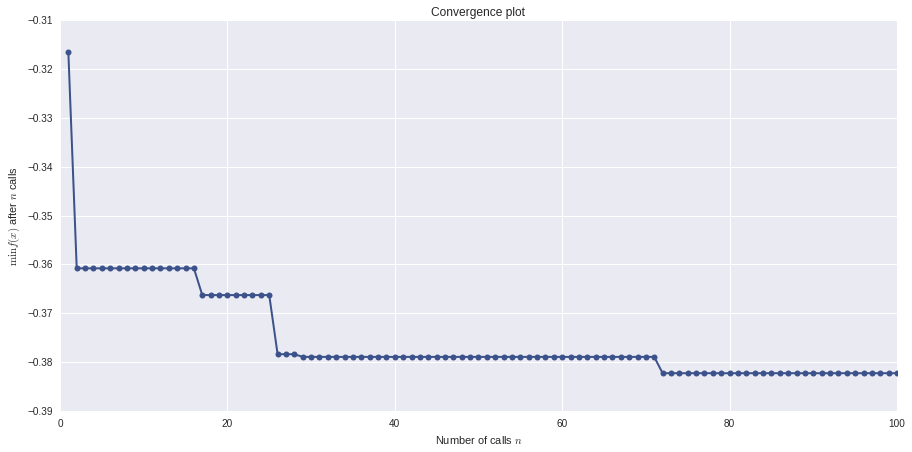

In [123]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [124]:
alpha = res_gp.x[0]
alpha

10000.0

In [125]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [126]:
model = Ridge(alpha=alpha).fit(final_xx_train, final_yy_train)

In [127]:
print "coefficient of determination for Ridge regression"
coef_deter = model.score(XX_test, yy_test)
coef_deter

coefficient of determination for Ridge regression


0.15512357586311987

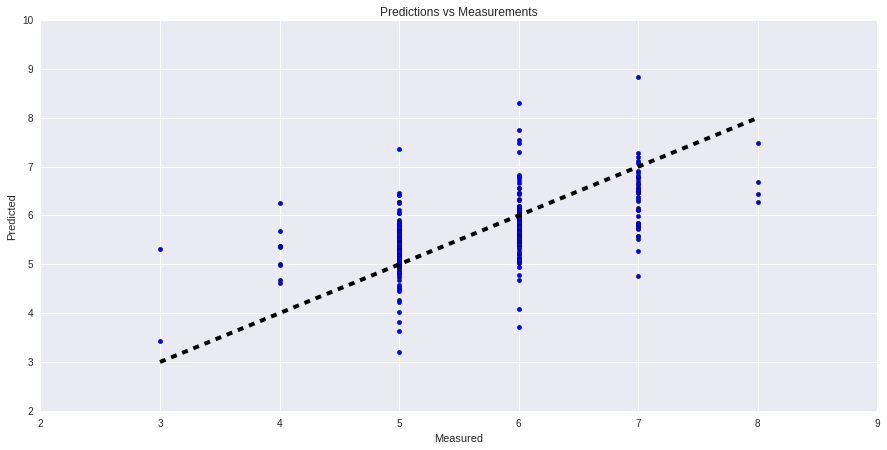

In [128]:
fit_scatter(y_true=yy_test, y_pred=model.predict(XX_test))
plt.title('Predictions vs Measurements')
plt.show()

In [129]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(model.predict(XX_test)))

score after predicting a fixed number of the quality


0.085642521471398392

In [130]:
models['ridge'] = model

In [131]:
from plot_confusion_matrix import plot_confusion_matrix

In [132]:
available_classes = np.unique(yy_test)
available_classes

array([3, 4, 5, 6, 7, 8])

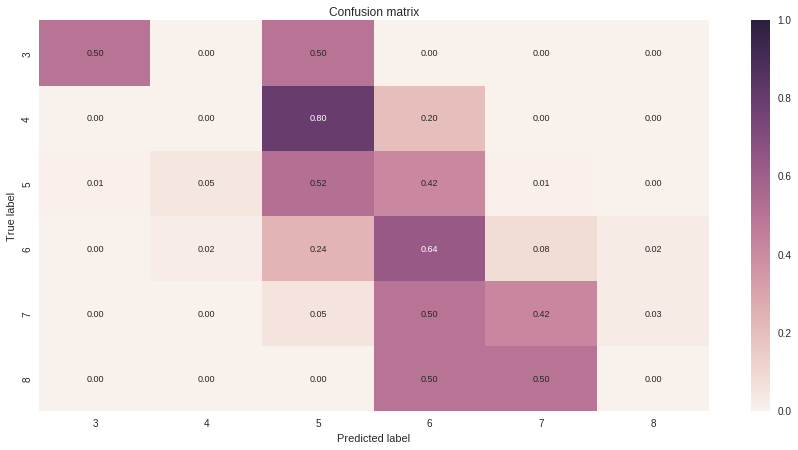

In [133]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(model.predict(XX_test)), normalized=True,
                      classes=available_classes)
plt.show()

In [134]:
preds = model.predict(XX_test)

In [135]:
score_classifier(y_true=yy_test, y_pred=preds)

0.35150675195451314

# Elastic Net

In [136]:
from sklearn.linear_model import ElasticNet

In [137]:
upsampling = True

In [138]:
XX_train.shape

(1217, 363)

In [139]:
def objective(params):
    alpha, l1_ratio = params
    
    estimator = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
    
    start_time = time()
    average_score = cross_validate(estimator, upsampling=upsampling)
    
    global count
    count += 1
    print "{}), time: {}, params: {}, score: {}".format(count, time() - start_time, params, average_score)

    # We want to maximise average score, i.e. minimise minus score
    return -average_score

In [140]:
alpha = Real(low=1e-6, high=1e3, prior='log-uniform')
l1_ratio = Real(low=0.0, high=1.0, prior='uniform')
dimensions = [alpha, l1_ratio]
#x0 = [0.0]

In [141]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=100, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=25,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1), time: 0.268738985062, params: [53.636891720049469, 0.53133730016125325], score: 0.102626056946
2), time: 0.390070199966, params: [10.596010815905322, 0.053402976507818237], score: 0.287920624647


/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


3), time: 15.0890209675, params: [3.6415110779214279e-06, 0.75639053691294733], score: 0.292643556704
4), time: 0.237255096436, params: [336.44832629070203, 0.63570637581341516], score: 0.102621498565
5), time: 14.845785141, params: [6.552677901243729e-05, 0.82339115168176635], score: 0.28800794394
6), time: 0.296399116516, params: [3.9335574260570167, 0.29174654934901728], score: 0.254516898093
7), time: 14.727823019, params: [1.2033065703048962e-06, 0.68771617479379255], score: 0.313775697194
8), time: 14.9314959049, params: [0.00020823773155220153, 0.52914088830277006], score: 0.304252705261
9), time: 14.611495018, params: [1.7655116510623997e-06, 0.53824178515949384], score: 0.329157733086
10), time: 14.6037549973, params: [0.00024763650163496504, 0.72010109665324318], score: 0.301382224748
11), time: 2.61364603043, params: [0.080363693363381825, 0.51433943414040639], score: 0.330013083562
12), time: 14.7510561943, params: [2.8185746236503595e-06, 0.91360725998953707], score: 0.305

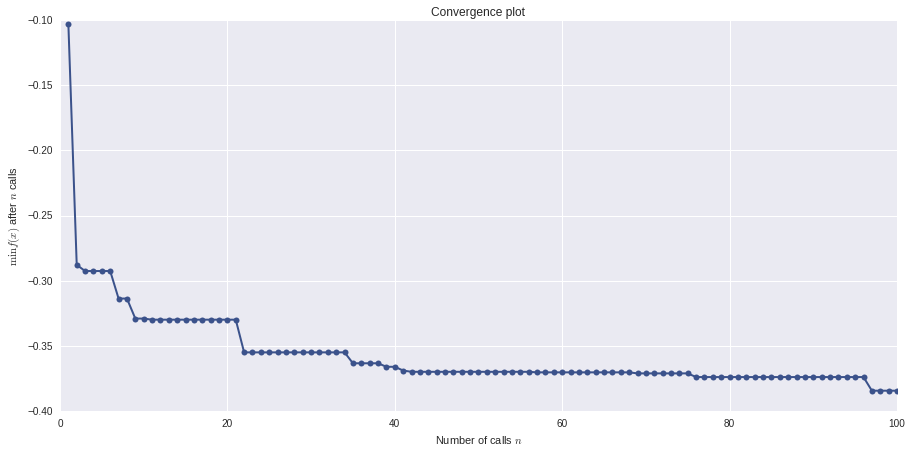

In [142]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [143]:
alpha, l1_ratio = res_gp.x
alpha, l1_ratio

(0.056212115235743425, 0.71922466744649705)

In [144]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [145]:
model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio).fit(final_xx_train, final_yy_train)

In [146]:
print "coefficient of determination for Elastic Net regression"
coef_deter = model.score(XX_test, yy_test)
coef_deter

coefficient of determination for Elastic Net regression


0.075835507133785729

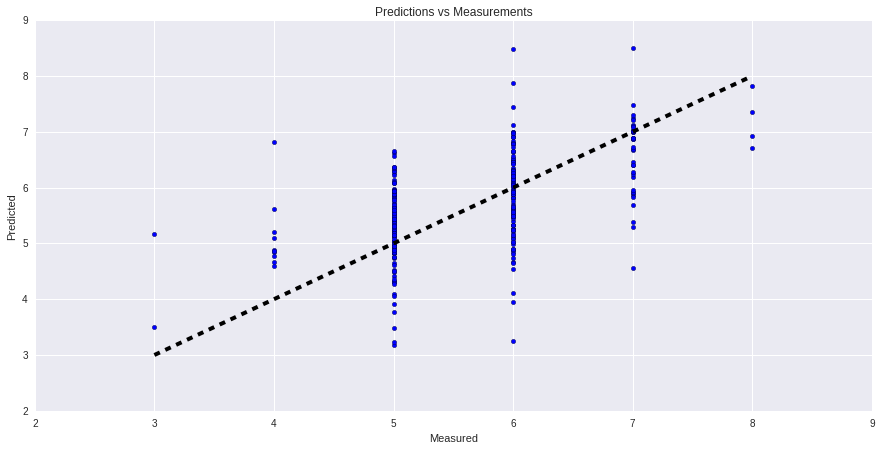

In [147]:
fit_scatter(y_true=yy_test, y_pred=model.predict(XX_test))
plt.title('Predictions vs Measurements')
plt.show()

In [148]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(model.predict(XX_test)))

score after predicting a fixed number of the quality


-0.023091881380651547

In [149]:
models['elastic_net'] = model

In [150]:
preds = model.predict(XX_test)
preds.shape

(305,)

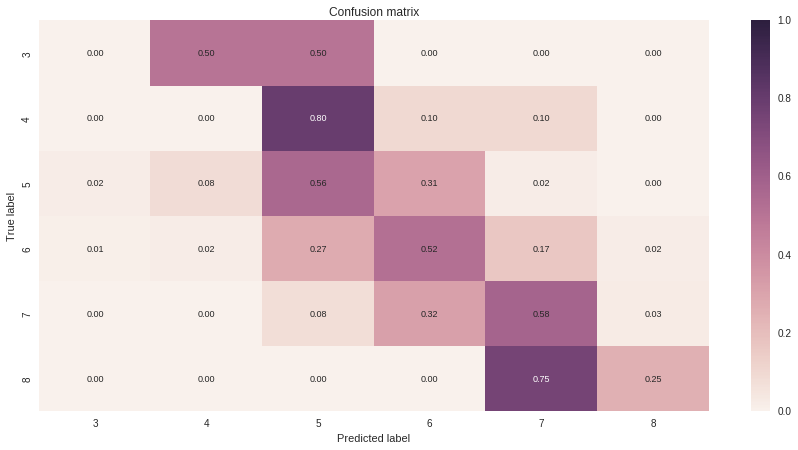

In [151]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(preds), normalized=True,
                      classes=available_classes)
plt.show()

In [152]:
score_classifier(y_true=yy_test, y_pred=preds)

0.31268372891273161

## KNN Regressor

In [153]:
from sklearn.neighbors import KNeighborsRegressor

In [154]:
upsampling = True

In [155]:
def objective(params):
    n_neighbors = params[0]
    estimator = KNeighborsRegressor(n_neighbors=n_neighbors)
    
    global upsampling
    start_time = time()
    average_score = cross_validate(estimator, inputs=XX_lowdim_train, upsampling=upsampling)
    
    global count
    count += 1
    print "{}), time: {}, params: {}, score: {}".format(count, time() - start_time, params, average_score)
    
    # We want to maximise average f1 score, i.e. minimise minus f1 score
    return -average_score

In [156]:
dimensions = [
    Integer(low=1, high=300)
]
x0 = [1]

In [157]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    x0=x0, #inital values for the hyper-parameters
    n_calls=100, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=25,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1), time: 0.0530250072479, params: [1], score: 0.342684567598
2), time: 0.0715789794922, params: [106], score: 0.239487131516
3), time: 0.0538167953491, params: [29], score: 0.286302650876
4), time: 0.0610589981079, params: [62], score: 0.275455625353
5), time: 0.110709905624, params: [293], score: 0.238850090111
6), time: 0.0611999034882, params: [66], score: 0.262197144449
7), time: 0.0740370750427, params: [129], score: 0.241971393392
8), time: 0.0976591110229, params: [229], score: 0.242832668746
9), time: 0.0848848819733, params: [172], score: 0.236312753837
10), time: 0.0854210853577, params: [175], score: 0.244180551613
11), time: 0.100536108017, params: [252], score: 0.245512211982
12), time: 0.0740330219269, params: [142], score: 0.259247652245
13), time: 0.0715758800507, params: [149], score: 0.239860710767
14), time: 0.0574989318848, params: [73], score: 0.259362699645
15), time: 0.0677428245544, params: [125], score: 0.232904733206
16), time: 0.0648860931396, params: [116],

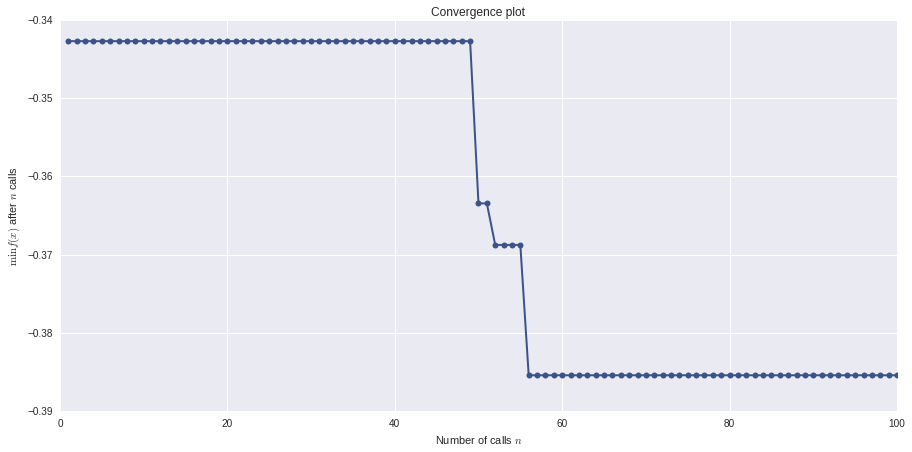

In [158]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [159]:
n_neighbors = res_gp.x[0]
n_neighbors

1

In [160]:
final_xx_train, final_yy_train = upsample(XX_lowdim_train, yy_train) if upsampling else (XX_lowdim_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 3), (3108,))

In [161]:
model = KNeighborsRegressor(n_neighbors=n_neighbors).fit(final_xx_train, final_yy_train)

In [162]:
print "coefficient of determination for K-Neighbors regression"
coef_deter = model.score(XX_lowdim_test, yy_test)
coef_deter

coefficient of determination for K-Neighbors regression


0.085642521471398392

In [163]:
preds = model.predict(XX_lowdim_test)
preds[:5], preds.shape

(array([ 7.,  6.,  6.,  6.,  6.]), (305,))

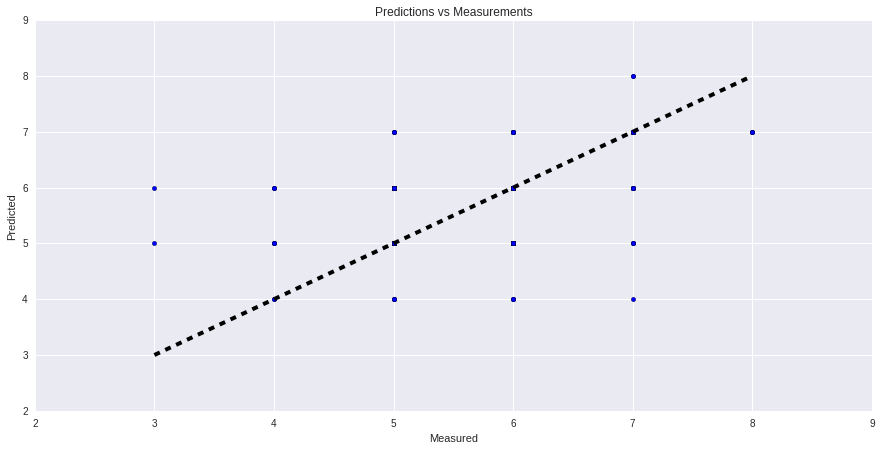

In [164]:
fit_scatter(y_true=yy_test, y_pred=preds)
plt.title('Predictions vs Measurements')
plt.show()

In [165]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(preds))

score after predicting a fixed number of the quality


0.085642521471398392

In [166]:
models['knn'] = model

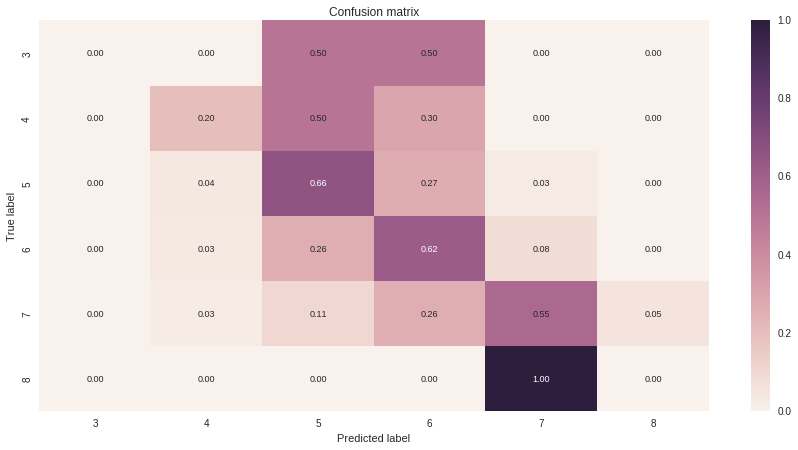

In [167]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(preds), normalized=True,
                      classes=available_classes)
plt.show()

In [168]:
score_classifier(y_true=yy_test, y_pred=preds)

0.33436404864976299

## Random Forest Regressor

In [169]:
from sklearn.ensemble import RandomForestRegressor

In [170]:
upsampling = True

In [171]:
def objective(params):
    n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = params
    
    estimator = RandomForestRegressor(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf
    )
    
    start_time = time()
    average_score = cross_validate(estimator, inputs=XX_train, targets=yy_train, upsampling=upsampling)
    
    global count
    count += 1
    print "{}), time: {}, params: {}, score: {}".format(count, time() - start_time, params, average_score)
    
    # We want to maximise average score, i.e. minimise minus score
    return -average_score

In [172]:
max_feats = XX_train.shape[1]
max_feats

363

In [173]:
from math import ceil, sqrt

In [174]:
n_estimators = Integer(low=10, high=100)
criterion = Categorical(['mse', 'mae'])
max_features = Integer(low=1, high=int(ceil(sqrt(max_feats))))
max_depth = Integer(low=1, high=30)
min_samples_split = Integer(low=2, high=100)
min_samples_leaf = Integer(low=1, high=100)

dimensions = [n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf]

In [175]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=50, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=20,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1), time: 1.84382510185, params: [39, 'mse', 5, 29, 78, 90], score: 0.329768039227
2), time: 1.15869283676, params: [37, 'mse', 1, 9, 71, 98], score: 0.235515864212
3), time: 1.42792391777, params: [45, 'mse', 1, 22, 92, 42], score: 0.24986168603
4), time: 79.3391730785, params: [56, 'mae', 16, 16, 52, 57], score: 0.232897366264
5), time: 0.848975896835, params: [21, 'mse', 3, 7, 95, 65], score: 0.296942020913
6), time: 91.299893856, params: [63, 'mae', 18, 17, 44, 85], score: 0.197515483711
7), time: 28.0713760853, params: [17, 'mae', 12, 9, 92, 6], score: 0.331153048145
8), time: 3.08734607697, params: [35, 'mse', 16, 11, 6, 75], score: 0.332023578419
9), time: 26.0779399872, params: [42, 'mae', 5, 20, 58, 72], score: 0.33150390935
10), time: 7.15352702141, params: [67, 'mse', 17, 21, 72, 27], score: 0.373625748987
11), time: 17.9132678509, params: [15, 'mae', 11, 26, 41, 49], score: 0.301380159631
12), time: 2.24726819992, params: [24, 'mse', 13, 20, 4, 28], score: 0.367511319673
13

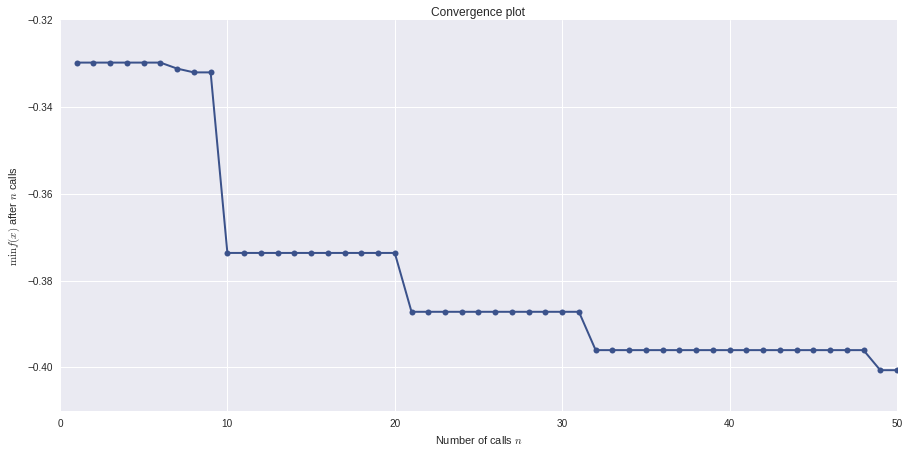

In [176]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [177]:
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf = res_gp.x
n_estimators, criterion, max_features, max_depth, min_samples_split, min_samples_leaf

(10, 'mse', 20, 30, 2, 1)

In [178]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [179]:
model = RandomForestRegressor(
        n_estimators=n_estimators, criterion=criterion, max_features=max_features, max_depth=max_depth,
        min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf
    ).fit(final_xx_train, final_yy_train)

In [180]:
print "coefficient of determination for Random Forest Regressor"
coef_deter = model.score(XX_test, yy_test)
coef_deter

coefficient of determination for Random Forest Regressor


0.41688705234159773

In [181]:
preds = model.predict(XX_test)

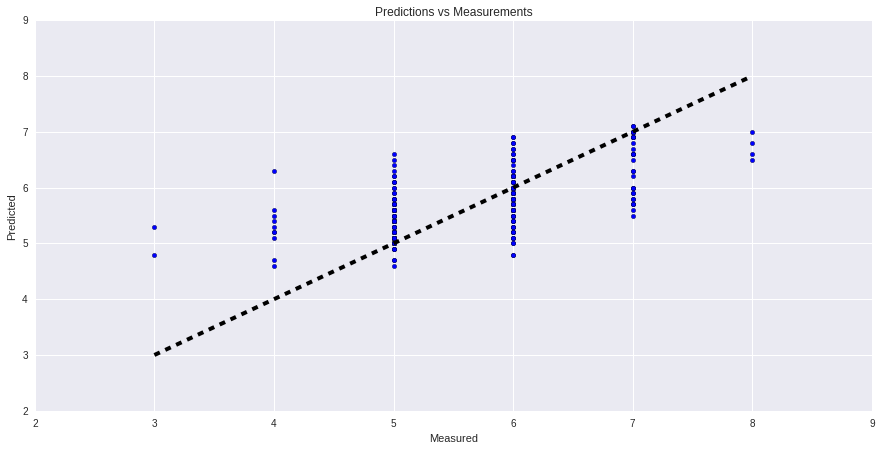

In [182]:
fit_scatter(y_true=yy_test, y_pred=preds)
plt.title('Predictions vs Measurements')
plt.show()

In [183]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(preds))

score after predicting a fixed number of the quality


0.35253605574461189

In [184]:
models['random_forest'] = model

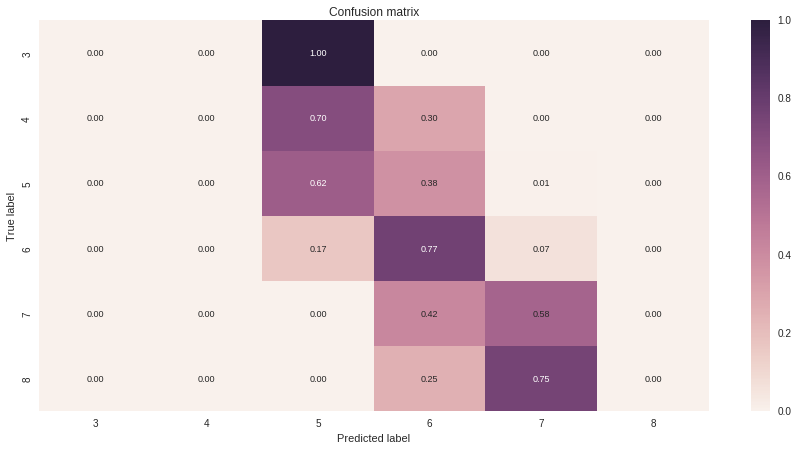

In [185]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(preds), normalized=True,
                      classes=available_classes)
plt.show()

In [186]:
score_classifier(y_true=yy_test, y_pred=preds)

0.32296849905185582

## MLP Regressor

In [187]:
from sklearn.neural_network import MLPRegressor

In [188]:
def get_model(activation, alpha, learning_rate_init, early_stopping=True, max_iter = 500, tol = 1e-4):
    return MLPRegressor(
        hidden_layer_sizes=(100, 50, 10),
        activation=activation,
        alpha=alpha,
        learning_rate_init=learning_rate_init,
        max_iter = max_iter,
        shuffle=True,
        random_state=random_state,
        tol = tol,
        early_stopping = early_stopping,
    )

In [189]:
activation=Categorical(['relu', 'logistic', 'tanh'])
alpha = Real(low=1e-5, high=1e0, prior='log-uniform')
learning_rate_init = Real(low=1e-5, high=1e-1, prior='log-uniform')

dimensions = [activation, alpha, learning_rate_init]

In [190]:
from time import time

In [191]:
upsampling = True

In [192]:
def objective(params):
    activation, alpha, learning_rate_init = params
    
    global count
    count += 1
    print "{}: {}".format(count, params)
    
    #(learning_rate=’constant’, learning_rate_init=0.001, power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False, momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-08
    
    
    estimator = get_model(activation, alpha, learning_rate_init)
    
    start_time = time()
    global upsampling
    average_score = cross_validate(estimator, inputs=XX_train, targets=yy_train, upsampling=upsampling)
    print "lasted: {} and average score is: {}".format(time() - start_time, average_score)
    
    # We want to maximise average score, i.e. minimise minus score
    return -average_score

In [193]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=30, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=10,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1: ['relu', 0.0046946835048885865, 0.00054766733372161951]
lasted: 27.5497989655 and average score is: 0.307687651061
2: ['relu', 0.011508313160710125, 0.0051590540951868338]
lasted: 10.0169639587 and average score is: 0.325135091956
3: ['relu', 0.017671529071739495, 0.0040513793716518013]
lasted: 8.19380807877 and average score is: 0.300024329292
4: ['logistic', 0.10272558389872037, 0.070094068934410073]
lasted: 7.57343101501 and average score is: 0.199731383767
5: ['relu', 0.11121977685333879, 0.00038416559966212519]
lasted: 26.7694129944 and average score is: 0.267050990485
6: ['tanh', 0.022572227525354073, 0.00070641111292673274]
lasted: 51.5523979664 and average score is: 0.38119932762
7: ['logistic', 0.66047216106074225, 0.093994514469228865]
lasted: 7.78696084023 and average score is: 0.333037420225
8: ['tanh', 0.0025000603554087043, 0.0013101263111460824]
lasted: 37.9678862095 and average score is: 0.359341903486
9: ['relu', 0.0059005328178744678, 0.034480631346229293]
lasted: 

/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


lasted: 263.306110859 and average score is: 0.0782194561123
13: ['logistic', 1.0000000000000001e-05, 1.0000000000000001e-05]
lasted: 243.623183966 and average score is: 0.00163289614573
14: ['logistic', 0.009634646852610642, 1.0000000000000001e-05]
lasted: 251.855468035 and average score is: 0.00163074560809
15: ['relu', 1.3810283878585496e-05, 1.0000000000000001e-05]
lasted: 222.560799122 and average score is: 0.143445551973
16: ['logistic', 1.0, 0.0019534664336368262]
lasted: 50.8210520744 and average score is: 0.340627730241
17: ['tanh', 0.0092995630012224235, 1.0000000000000001e-05]
lasted: 274.127522945 and average score is: 0.0440820343529
18: ['tanh', 1.0000000000000001e-05, 0.0025849561796665822]
lasted: 22.7554140091 and average score is: 0.367747046612
19: ['logistic', 1.0000000000000001e-05, 0.0042098296015029889]
lasted: 15.5447161198 and average score is: 0.125528491969
20: ['relu', 0.014894948710618427, 0.0018221476638601646]
lasted: 11.9020500183 and average score is: 0.

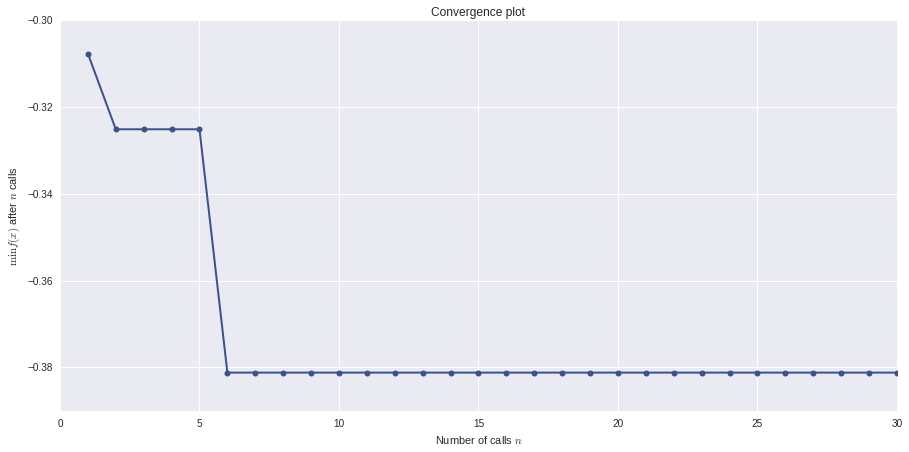

In [194]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [195]:
activation, alpha, learning_rate_init = res_gp.x
activation, alpha, learning_rate_init

('tanh', 0.022572227525354073, 0.00070641111292673274)

In [196]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [197]:
%%time
model = get_model(activation, alpha, learning_rate_init, early_stopping=False, max_iter = 2000, tol = 1e-5).fit(
    final_xx_train, final_yy_train)

CPU times: user 27.9 s, sys: 380 ms, total: 28.3 s
Wall time: 7.12 s


In [198]:
print "coefficient of determination for Multi-Layer Perceptron Neural Network Regressor"
coef_deter = model.score(XX_test, yy_test)
coef_deter

coefficient of determination for Multi-Layer Perceptron Neural Network Regressor


-0.31618333707169222

In [199]:
preds = model.predict(XX_test)

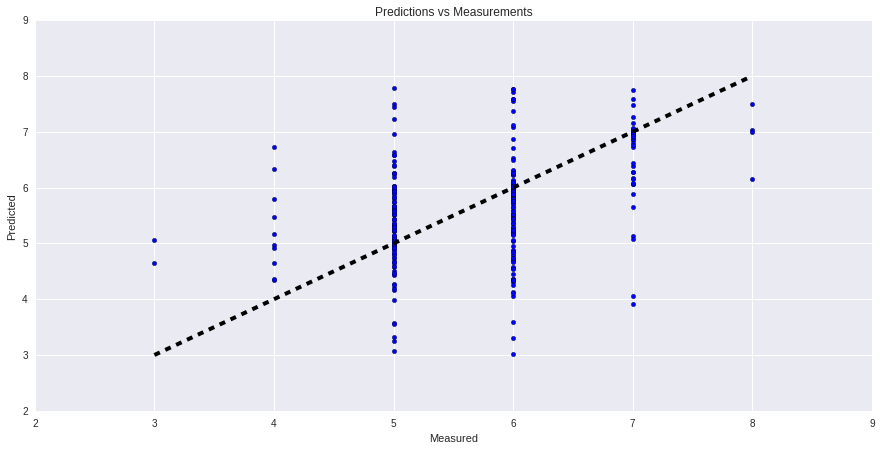

In [200]:
fit_scatter(y_true=yy_test, y_pred=preds)
plt.title('Predictions vs Measurements')
plt.show()

In [201]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(preds))

score after predicting a fixed number of the quality


-0.4777993842164967

In [202]:
models['mlp'] = model

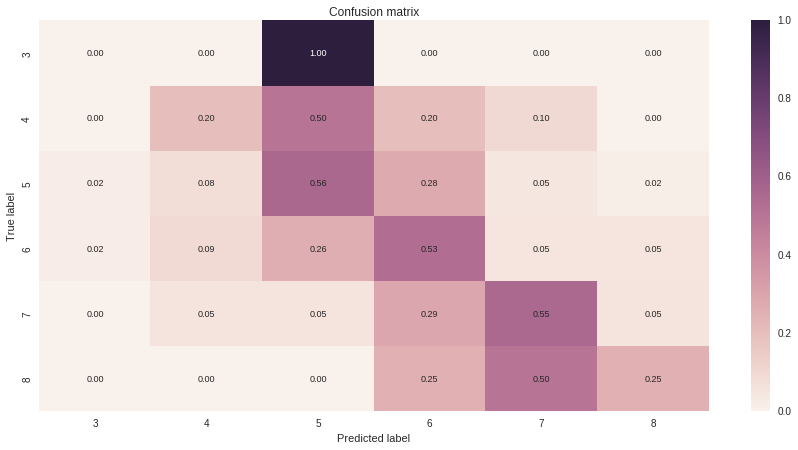

In [203]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(preds), normalized=True,
                      classes=available_classes)
plt.show()

In [204]:
score_classifier(y_true=yy_test, y_pred=preds)

0.32637135366469167

# Gaussian Process Regressor

In [205]:
from sklearn.gaussian_process import GaussianProcessRegressor

In [206]:
def get_model(normalize_y, n_restarts_optimizer=10):
    return GaussianProcessRegressor(
        n_restarts_optimizer = n_restarts_optimizer,
        normalize_y = normalize_y
    )

In [207]:
%%time
model1 = get_model(normalize_y=False)
average_score1 = cross_validate(model1, inputs=XX_train, targets=yy_train, upsampling=True)
print average_score1

0.182818693064
CPU times: user 2min, sys: 2.3 s, total: 2min 3s
Wall time: 51.9 s


In [208]:
%%time
model2 = get_model(normalize_y=True) #normalizing targets was necessary after all
average_score2 = cross_validate(model2, inputs=XX_train, targets=yy_train, upsampling=True)
print average_score2

0.312267201971
CPU times: user 2min, sys: 2.29 s, total: 2min 2s
Wall time: 50.8 s


In [209]:
final_xx_train, final_yy_train = upsample(XX_train, yy_train) if upsampling else (XX_train, yy_train)
final_xx_train.shape, final_yy_train.shape

((3108, 363), (3108,))

In [210]:
normalize_y = average_score2 > average_score1
normalize_y

True

In [211]:
%%time
model = get_model(normalize_y=normalize_y).fit(final_xx_train, final_yy_train)

CPU times: user 13.1 s, sys: 216 ms, total: 13.3 s
Wall time: 6.24 s


In [212]:
print "coefficient of determination for Multi-Layer Perceptron Neural Network Regressor"
coef_deter = model.score(XX_test, yy_test)
coef_deter

coefficient of determination for Multi-Layer Perceptron Neural Network Regressor


0.16517923458027783

In [213]:
preds = model.predict(XX_test)

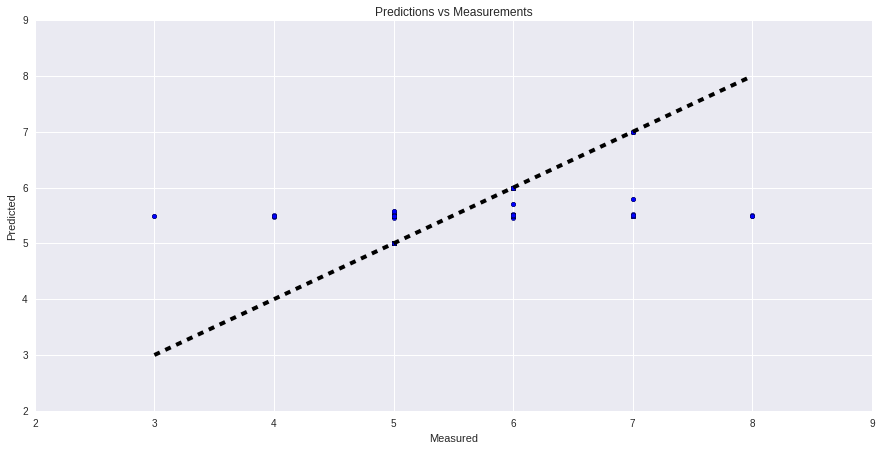

In [214]:
fit_scatter(y_true=yy_test, y_pred=preds)
plt.title('Predictions vs Measurements')
plt.show()

In [215]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(model.predict(XX_test)))

score after predicting a fixed number of the quality


0.11529735861286661

In [216]:
models['gp'] = model

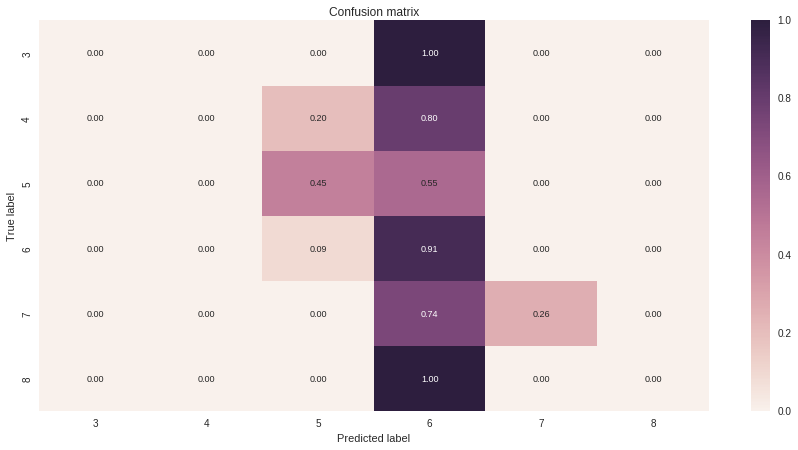

In [217]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(preds), normalized=True,
                      classes=available_classes)
plt.show()

In [218]:
score_classifier(y_true=yy_test, y_pred=preds)

0.27191037565794224

# Ensemble - Linear Model of above models
Here we are building a model that is a linear combination of the outputs of all the other models in an attempt to improve our overall score.

So the predictions of the other models are going to be features of our new model. The targets are going to be the same. To avoid overfitting effects we are fitting these models on 80% of the training dataset. Then these models are going to be trained on the rest of the 20% of the training dataset

In [219]:
models.keys()

['ridge', 'elastic_net', 'knn', 'random_forest', 'mlp', 'gp']

In [220]:
sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=0.2)
sss

StratifiedShuffleSplit(n_splits=1,
            random_state=<mtrand.RandomState object at 0x7f9a17932820>,
            test_size=0.2, train_size=None)

In [221]:
fitting_indices, train_ensemble_indices = sss.split(XX_train, yy_train).next()    
fitting_indices.shape, train_ensemble_indices.shape

((973,), (244,))

In [222]:
XX_fitting = XX_train[fitting_indices]
yy_fitting = yy_train[fitting_indices]
XX_fitting.shape, yy_fitting.shape

((973, 363), (973,))

In [223]:
XX_train_ensemble = XX_train[train_ensemble_indices]
yy_train_ensemble = yy_train[train_ensemble_indices]
XX_train_ensemble.shape, yy_train_ensemble.shape

((244, 363), (244,))

In [224]:
XX_lowdim_fitting = XX_lowdim_train[fitting_indices]
XX_lowdim_fitting.shape

(973, 3)

In [225]:
XX_lowdim_train_ensemble = XX_lowdim_train[train_ensemble_indices]
XX_lowdim_train_ensemble.shape

(244, 3)

In [226]:
def ensemble_fit_predict(xx_lowdim_fit, xx_fit, yy_fit, xx_lowdim_pred, xx_pred, ):
    global models
    return pd.DataFrame(OrderedDict([
        (key, model.fit(xx_lowdim_fit, yy_fit).predict(xx_lowdim_pred) if key == 'knn' else
                                model.fit(xx_fit, yy_fit).predict(xx_pred) )
                          for key, model in models.iteritems()]))

In [227]:
def ensemble_fit_predict_wrapper(xx_lowdim, xx, y_vec, test_size=0.2):
    sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=test_size)
    fit_inds, pred_inds = sss.split(xx, y_vec).next()
    return ensemble_fit_predict(xx_lowdim_fit=xx_lowdim[fit_inds], xx_fit=xx[fit_inds],
                                yy_fit=y_vec[fit_inds], xx_lowdim_pred=xx_lowdim[pred_inds],
                                xx_pred=xx[pred_inds]), y_vec[pred_inds]

In [228]:
%%time
preds_df = ensemble_fit_predict(xx_lowdim_fit=XX_lowdim_fitting, xx_fit=XX_fitting,
                                yy_fit=yy_fitting, xx_lowdim_pred=XX_lowdim_train_ensemble,
                                xx_pred=XX_train_ensemble)

CPU times: user 40.6 s, sys: 684 ms, total: 41.3 s
Wall time: 10.5 s


In [229]:
print preds_df.shape
preds_df.sample(3)

(244, 6)


,ridge,elastic_net,knn,random_forest,mlp,gp
90,5.724137,5.820924,7.0,6.7,6.859353,7.0
86,5.583097,5.604251,6.0,6.0,6.142974,6.0
55,5.719512,5.874206,6.0,5.9,5.937234,6.0


In [230]:
from sklearn.model_selection import StratifiedKFold

In [231]:
kFold = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

In [232]:
def cross_validate_ensemble(estimator, lowdim_inputs, inputs, targets, upsampling):
    indices_iterator = kFold.split(inputs) #3 splits here for speed
    assert len(lowdim_inputs) == len(inputs)
    
    scores = []    
    for train_inds, valid_inds in indices_iterator:
        cur_xx_train = inputs[train_inds]
        cur_lowdim_xx_train = lowdim_inputs[train_inds]
        cur_yy_train = targets[train_inds]
        #print cur_xx_train.shape, cur_lowdim_xx_train.shape, cur_yy_train.shape
        if upsampling:
            #upsample train inds to make them balanced
            upsampled_inds, cur_yy_train = upsample(np.arange(len(cur_xx_train)).reshape(-1, 1), cur_yy_train)
            upsampled_inds = upsampled_inds.flatten()
            cur_lowdim_xx_train = cur_lowdim_xx_train[upsampled_inds]
            cur_xx_train = cur_xx_train[upsampled_inds]
            
        #print cur_xx_train.shape, cur_lowdim_xx_train.shape, cur_yy_train.shape
        
        #keep valid inds intact
        cur_xx_valid = inputs[valid_inds]
        cur_lowdim_xx_valid = lowdim_inputs[valid_inds]
        cur_yy_valid = targets[valid_inds]
        
        preds_df, yy_train_subsample = ensemble_fit_predict_wrapper(xx_lowdim=cur_lowdim_xx_train, xx=cur_xx_train,
                                                                    y_vec=cur_yy_train, test_size=0.2)
        
        estimator.fit(preds_df.values, yy_train_subsample) #fit ridge model to the predictions
        #cur_score = estimator.score(cur_xx_valid, cur_yy_valid)
        
        #use models to create new predictions based on the cur_xx_valid, but you have to fit them on train data
        valid_preds_df = ensemble_fit_predict(xx_lowdim_fit=cur_lowdim_xx_train, xx_fit=cur_xx_train,
                                              yy_fit=cur_yy_train, xx_lowdim_pred=cur_lowdim_xx_valid,
                                              xx_pred=cur_xx_valid)
        
        #then use this fitted ridge model and the predictions to create the actual predicted values
        cur_preds = estimator.predict(valid_preds_df.values)
        cur_score = score_classifier(y_true = cur_yy_valid, y_pred=cur_preds)
        scores.append(cur_score)
        
    return np.mean(scores)

In [233]:
def holdout_validate_ensemble(estimator, lowdim_inputs, inputs, targets, upsampling, hold_out=0.2):
    assert len(lowdim_inputs) == len(inputs)
    
    sss = StratifiedShuffleSplit(n_splits=1, random_state=random_state, test_size=hold_out)
    train_inds, valid_inds = sss.split(inputs, targets).next() 
  
    cur_xx_train = inputs[train_inds]
    cur_lowdim_xx_train = lowdim_inputs[train_inds]
    cur_yy_train = targets[train_inds]
    #print cur_xx_train.shape, cur_lowdim_xx_train.shape, cur_yy_train.shape
    if upsampling:
        #upsample train inds to make them balanced
        upsampled_inds, cur_yy_train = upsample(np.arange(len(cur_xx_train)).reshape(-1, 1), cur_yy_train)
        upsampled_inds = upsampled_inds.flatten()
        cur_lowdim_xx_train = cur_lowdim_xx_train[upsampled_inds]
        cur_xx_train = cur_xx_train[upsampled_inds]

    #print cur_xx_train.shape, cur_lowdim_xx_train.shape, cur_yy_train.shape

    #keep valid inds intact
    cur_xx_valid = inputs[valid_inds]
    cur_lowdim_xx_valid = lowdim_inputs[valid_inds]
    cur_yy_valid = targets[valid_inds]
    
    #predictors build models for valid set

    train_preds_df, yy_train_subsample = ensemble_fit_predict_wrapper(xx_lowdim=cur_lowdim_xx_train,
                                                                      xx=cur_xx_train,
                                                                      y_vec=cur_yy_train, test_size=0.2)
    #print train_preds_df.shape

    estimator.fit(train_preds_df.values, yy_train_subsample) #fit ridge model to the predictions
    #cur_score = estimator.score(cur_xx_valid, cur_yy_valid)
    #print estimator.coef_

    #use models to create new predictions based on the cur_xx_valid, but you have to fit them on train data
    valid_preds_df = ensemble_fit_predict(xx_lowdim_fit=cur_lowdim_xx_train, xx_fit=cur_xx_train,
                                          yy_fit=cur_yy_train, xx_lowdim_pred=cur_lowdim_xx_valid,
                                          xx_pred=cur_xx_valid)
    #print valid_preds_df.shape

    #then use this fitted ridge model and the predictions to create the actual predicted values
    cur_preds = estimator.predict(valid_preds_df.values)
    cur_score = score_classifier(y_true=cur_yy_valid, y_pred=cur_preds)
    return cur_score

In [234]:
upsampling = True

In [235]:
def objective(params):
    alpha = params[0]
    estimator = Ridge(alpha=alpha)
    
    global upsampling
    start_time = time()
    score = holdout_validate_ensemble(estimator, lowdim_inputs=XX_lowdim_train, inputs=XX_train,
                                      targets=yy_train, upsampling=upsampling)
    
    global count
    count += 1
    print "{}), time: {}, params: {}, score: {}".format(count, time() - start_time, params, score)
    
    # We want to maximise average score, i.e. minimise minus score
    return -score

In [236]:
dimensions = [
    Real(low=1e-4, high=1e2, prior='log-uniform')
]
#x0 = [0.0]

In [238]:
%%time
count = 0
res_gp = gp_minimize(
    func=objective, # function that we wish to minimise
    dimensions=dimensions, #the search space for the hyper-parameters
    #x0=x0, #inital values for the hyper-parameters
    n_calls=40, #number of times the function will be evaluated
    random_state=random_state, #random seed
    n_random_starts=15,  #before we start modelling the optimised function with a GP Regression
                        #model, we want to try a few random choices for the hyper-parameters.
    #kappa=1.9 #trade-off between exploration vs. exploitation.
)

1), time: 23.2030639648, params: [2.4626610350063762], score: 0.376352379777
2), time: 21.8222038746, params: [0.0029445288084398668], score: 0.359253106928
3), time: 19.8716921806, params: [9.8388531378369635], score: 0.402412509552
4), time: 19.6890408993, params: [0.00060134325415601379], score: 0.269901638816
5), time: 21.1240859032, params: [0.017916340405700899], score: 0.29992202729
6), time: 21.676459074, params: [3.1354854929182037], score: 0.287805223099
7), time: 20.8175401688, params: [0.1652033673273082], score: 0.372840213378
8), time: 21.1486079693, params: [0.00043895145549687045], score: 0.373643419399
9), time: 20.0301439762, params: [3.5934255917866791], score: 0.29897441301
10), time: 21.1690409184, params: [11.618521375858405], score: 0.31261284989
11), time: 20.3437719345, params: [5.6529556554399472], score: 0.386770674784
12), time: 22.8801460266, params: [31.772306869779147], score: 0.3083052395
13), time: 23.357088089, params: [35.61470121593689], score: 0.299

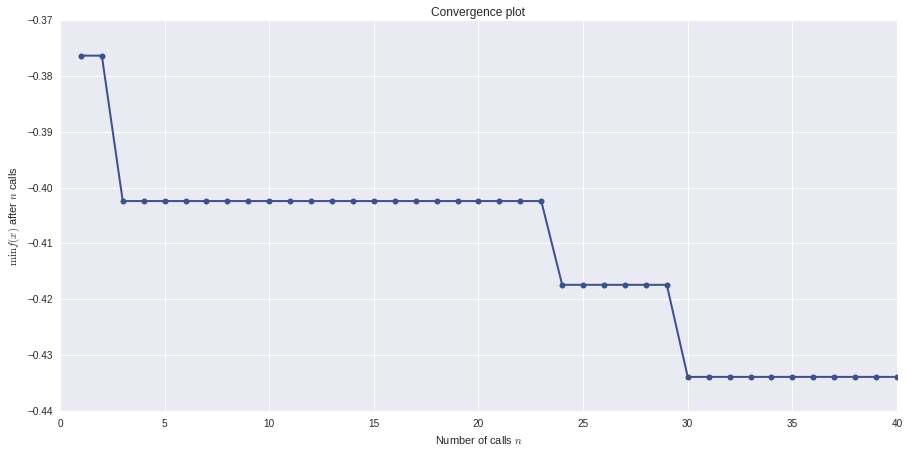

In [239]:
plot_convergence(res_gp)
plt.grid()
plt.show()

In [240]:
alpha = res_gp.x[0]
alpha

0.0001000648849109215

In [241]:
ensemble_model = Ridge(alpha=alpha)

In [242]:
train_preds_df, yy_train_subsample = ensemble_fit_predict_wrapper(xx_lowdim=XX_lowdim_train,
                                                                      xx=XX_train,
                                                                      y_vec=yy_train, test_size=0.2)
#print train_preds_df.shape

ensemble_model.fit(train_preds_df.values, yy_train_subsample)

Ridge(alpha=0.0001000648849109215, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [243]:
test_preds_df = ensemble_fit_predict(xx_lowdim_fit=XX_lowdim_train, xx_fit=XX_train,
                                     yy_fit=yy_train, xx_lowdim_pred=XX_lowdim_test,
                                     xx_pred=XX_test)

In [244]:
ensemble_preds = ensemble_model.predict(test_preds_df.values)
ensemble_preds.shape

(305,)

In [245]:
print "coefficient of determination for ensemble regressor"
coef_deter = r2_score(y_true=yy_test, y_pred=ensemble_preds)
coef_deter

coefficient of determination for ensemble regressor


0.47198994977394104

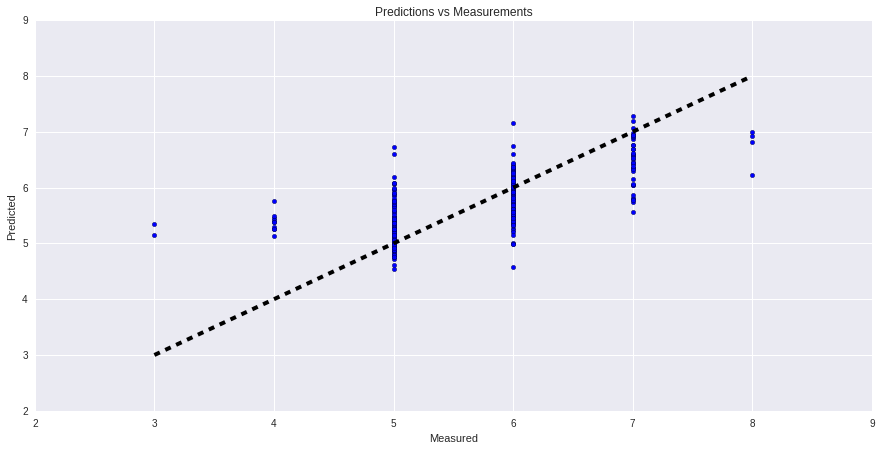

In [246]:
fit_scatter(y_true=yy_test, y_pred=ensemble_preds)
plt.title('Predictions vs Measurements')
plt.show()

In [247]:
print "score after predicting a fixed number of the quality"
r2_score(yy_test, purify_quality(ensemble_preds))

score after predicting a fixed number of the quality


0.44644304002592772

In [ ]:
#models['ensemble'] = ensemble_model

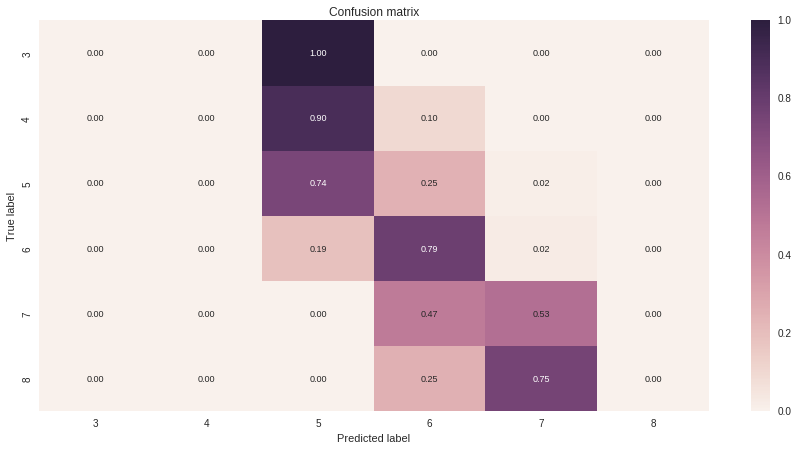

In [248]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(ensemble_preds), normalized=True,
                      classes=available_classes)
plt.show()

In [249]:
score_classifier(y_true=yy_test, y_pred=preds)

0.27191037565794224

# Comparing Models

In [250]:
models.keys()

['ridge', 'elastic_net', 'knn', 'random_forest', 'mlp', 'gp']

In [251]:
%%time
for key, model in models.iteritems():
    inputs, targets = (XX_lowdim_train, yy_train) if key == 'knn' else (XX_train, yy_train)
    model.fit(inputs, targets)

CPU times: user 22.6 s, sys: 344 ms, total: 22.9 s
Wall time: 5.76 s


In [255]:
score_dict = OrderedDict([(key, score_classifier(
                y_true=yy_test,y_pred=model.predict(XX_lowdim_test) if key == 'knn' else model.predict(XX_test)
            )) for (key, model) in models.iteritems()])

In [252]:
#score_dict = OrderedDict([(key, model.score(XX_test, yy_test)) for (key, model) in models.iteritems()])

In [259]:
score_dict['ensemble'] = score_classifier(yy_test, ensemble_preds)

In [260]:
score_df = pd.DataFrame(index=score_dict.keys(), data=score_dict.values(), columns=['f1_score']
                       ).sort_values('f1_score', ascending=False)
score_df

,f1_score
ensemble,0.342246
knn,0.334364
random_forest,0.314806
mlp,0.312323
gp,0.242238
elastic_net,0.234525
ridge,0.217551


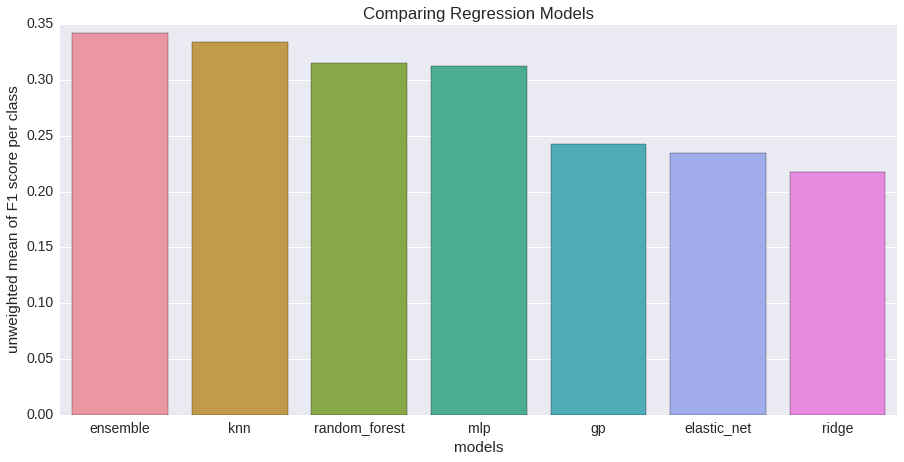

In [264]:
sns.set(font_scale=1.4)
plt.figure(figsize=(15,7))
sns.barplot(x=score_df.index, y=score_df['f1_score'], estimator=lambda xx: xx)
plt.ylabel('unweighted mean of F1 score per class')
plt.xlabel('models')
plt.title('Comparing Regression Models')
plt.show()

It is interesting to notice that our best regression model manages to achieve a similar F1 score to our classifiers

# Confusion Matrix

In [265]:
available_classes

array([3, 4, 5, 6, 7, 8])

In [266]:
from plot_confusion_matrix import plot_confusion_matrix

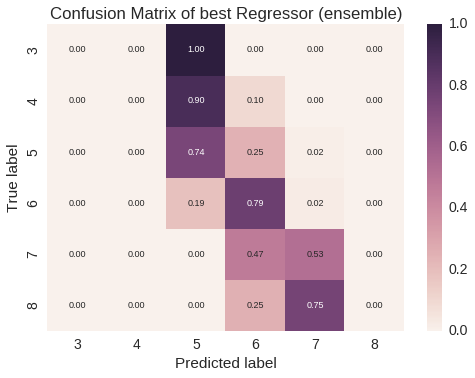

In [268]:
plot_confusion_matrix(y_true=yy_test, y_pred=purify_quality(ensemble_preds), normalized=True,
                      classes=available_classes,
                      title='Confusion Matrix of best Regressor (ensemble)')
plt.show()

In [269]:
from sklearn.metrics import classification_report

In [270]:
print classification_report(y_true=yy_test, y_pred=purify_quality(ensemble_preds))

             precision    recall  f1-score   support

          3       0.00      0.00      0.00         2
          4       0.00      0.00      0.00        10
          5       0.74      0.74      0.74       130
          6       0.65      0.79      0.71       121
          7       0.71      0.53      0.61        38
          8       0.00      0.00      0.00         4

avg / total       0.66      0.69      0.67       305



/home/student/anaconda2/envs/iaml/lib/python2.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
